<h1 style="text-align: center;">Main Allocation Core-Satellite</h1>


# Partie 1 : Import des packages classe et data du projet


In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from modules.my_packages.data import ExcelDataSource,BenchmarkDataSource,DataManager
from modules.my_packages.visualization import Visualizer
from modules.my_packages.utils import Utilities
from modules.my_packages.core_strategy import Backtester
from modules.my_packages.analysis import PerformanceAnalyser
from modules.my_packages.strategy import BuyAndHold, Momentum,DynamicAllocation,FactorStrategy
from modules.my_packages.portfolio import EqualWeightingScheme, NaiveRiskParity
from modules.my_packages.backtest import Backtest
from modules.my_packages.stats_utilities import Statistics


- ### Data Reading

In [2]:
#data reading ----------------------------------------------------------------------------------------------------------
# Define the path to the Excel file containing the data
BASE_DIR = os.getcwd()
excel_path = os.path.join(BASE_DIR, "data", "data_ETF_core_updated.xlsx")

# Create an ExcelDataSource object
price_source = ExcelDataSource(file_path=excel_path, sheet_name="data", index_col=0).fetch_data_core()
universe_returns = price_source.pct_change()
universe_returns = universe_returns.replace([np.inf, -np.inf], np.nan)

# Benchmark data
benchmark_path = os.path.join(BASE_DIR, "data", "Data_for_bench.xlsx")
date_columns = [0, 3]   # Indices of the columns containing the dates
value_columns = [1, 4]  # Indices of the columns containing the values

benchmark_source = BenchmarkDataSource(benchmark_path, date_columns, value_columns)
benchmark_data = benchmark_source.fetch_data()
benchmark_data.sort_index(inplace=True, ascending=True)
benchmark_returns = Utilities.compute_returns(benchmark_data)

fees_path = os.path.join(BASE_DIR, "data", "fees_core.xlsx")
fees_df = pd.read_excel(fees_path, index_col=0)
fees_df = fees_df/100

C:\Users\theod\AppData\Local\Temp\ipykernel_18848\4119005152.py:8: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  universe_returns = price_source.pct_change()


# Partie 2 : Construction du benchmark

- 50% LBEATREU - 50% MSCI WORLD

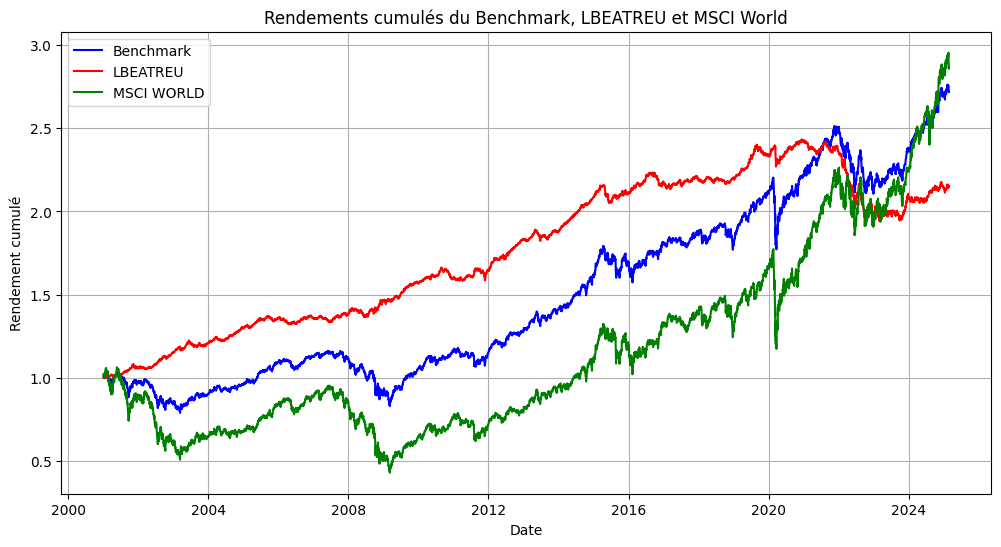

In [3]:
#Benchmark compute ---------------------------------------------------------------------------------------------------------
# Extract individual returns
LBEATREU = benchmark_returns.iloc[:, 0]
MSCI_WORLD = benchmark_returns.iloc[:, 1]

# Create a combined benchmark with a 50/50 weighting
combined_benchmark = 0.50 * LBEATREU + 0.50 * MSCI_WORLD

curves_to_plot = {"Benchmark": combined_benchmark,"LBEATREU": LBEATREU,"MSCI WORLD": MSCI_WORLD}  
        
# Data alignment
benchmark_returns_aligned, universe_returns_aligned = Utilities.align_dataframes(combined_benchmark, universe_returns)

# Calcul des rendements cumulés
LBEATREU_cumulative_returns = (1 + LBEATREU).cumprod()
MSCI_WORLD_cumulative_returns = (1 + MSCI_WORLD).cumprod()
benchmark_cumulative_returns = (1 + combined_benchmark).cumprod()

# Tracer les rendements cumulés du benchmark, LBEATREU et SBEB
plt.figure(figsize=(12, 6))

plt.plot(benchmark_cumulative_returns.index, benchmark_cumulative_returns, label="Benchmark", color="blue")
plt.plot(LBEATREU_cumulative_returns.index, LBEATREU_cumulative_returns, label="LBEATREU", color="red")
plt.plot(MSCI_WORLD_cumulative_returns.index, MSCI_WORLD_cumulative_returns, label="MSCI WORLD", color="green")

# Ajouter les labels et le titre
plt.xlabel("Date")
plt.ylabel("Rendement cumulé")
plt.title("Rendements cumulés du Benchmark, LBEATREU et MSCI World")
plt.legend()
plt.grid(True)

# Afficher le graphique
plt.show()

# Create a visualizer object
visualisation = Visualizer(benchmark_cumulative_returns)


# Partie 3 : Construction du portefeuille Core

Initialisation CORE : IR = -0.6206, TE ex ante = 0.0250
Date: 2015-12-31 00:00:00 | Combined TE ex post = nan
Date: 2016-01-04 00:00:00 | Combined TE ex post = nan
Date: 2016-01-05 00:00:00 | Combined TE ex post = nan
Date: 2016-01-06 00:00:00 | Combined TE ex post = nan
Date: 2016-01-07 00:00:00 | Combined TE ex post = nan
Date: 2016-01-08 00:00:00 | Combined TE ex post = nan
Date: 2016-01-11 00:00:00 | Combined TE ex post = nan
Date: 2016-01-12 00:00:00 | Combined TE ex post = nan
Date: 2016-01-13 00:00:00 | Combined TE ex post = nan
Date: 2016-01-14 00:00:00 | Combined TE ex post = nan
Date: 2016-01-15 00:00:00 | Combined TE ex post = nan
Date: 2016-01-18 00:00:00 | Combined TE ex post = nan
Date: 2016-01-19 00:00:00 | Combined TE ex post = nan
Date: 2016-01-20 00:00:00 | Combined TE ex post = nan
Date: 2016-01-21 00:00:00 | Combined TE ex post = nan
Date: 2016-01-22 00:00:00 | Combined TE ex post = nan
Date: 2016-01-25 00:00:00 | Combined TE ex post = nan
Date: 2016-01-26 00:00:00 

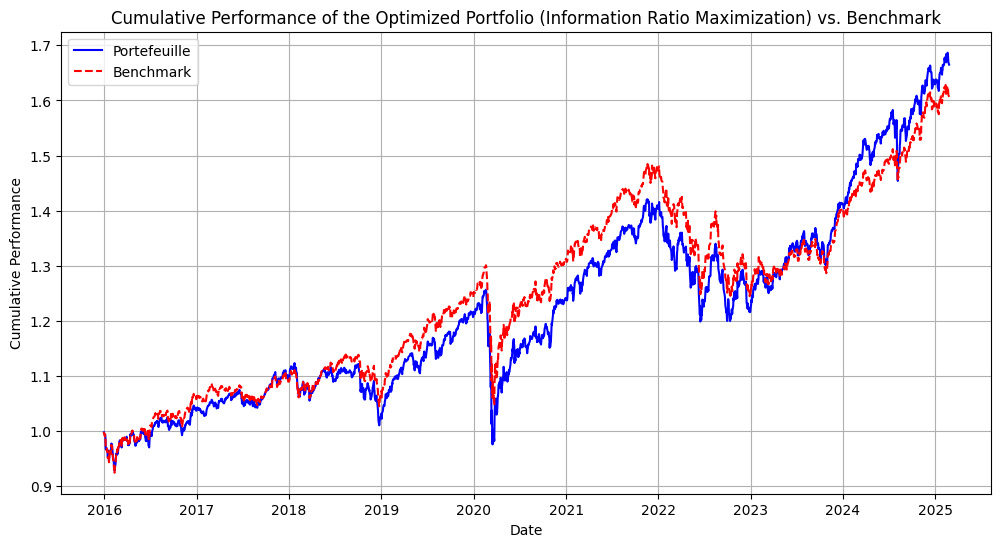

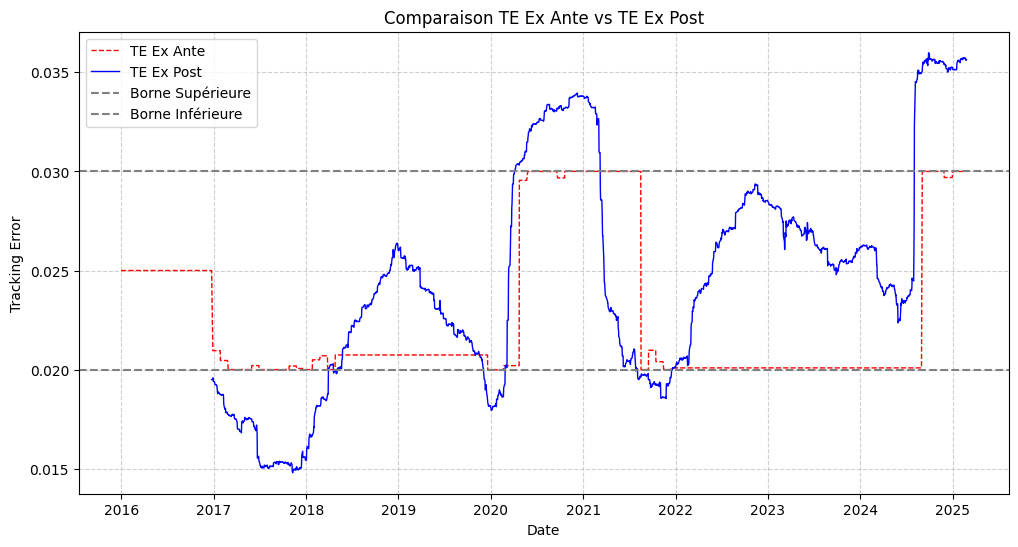

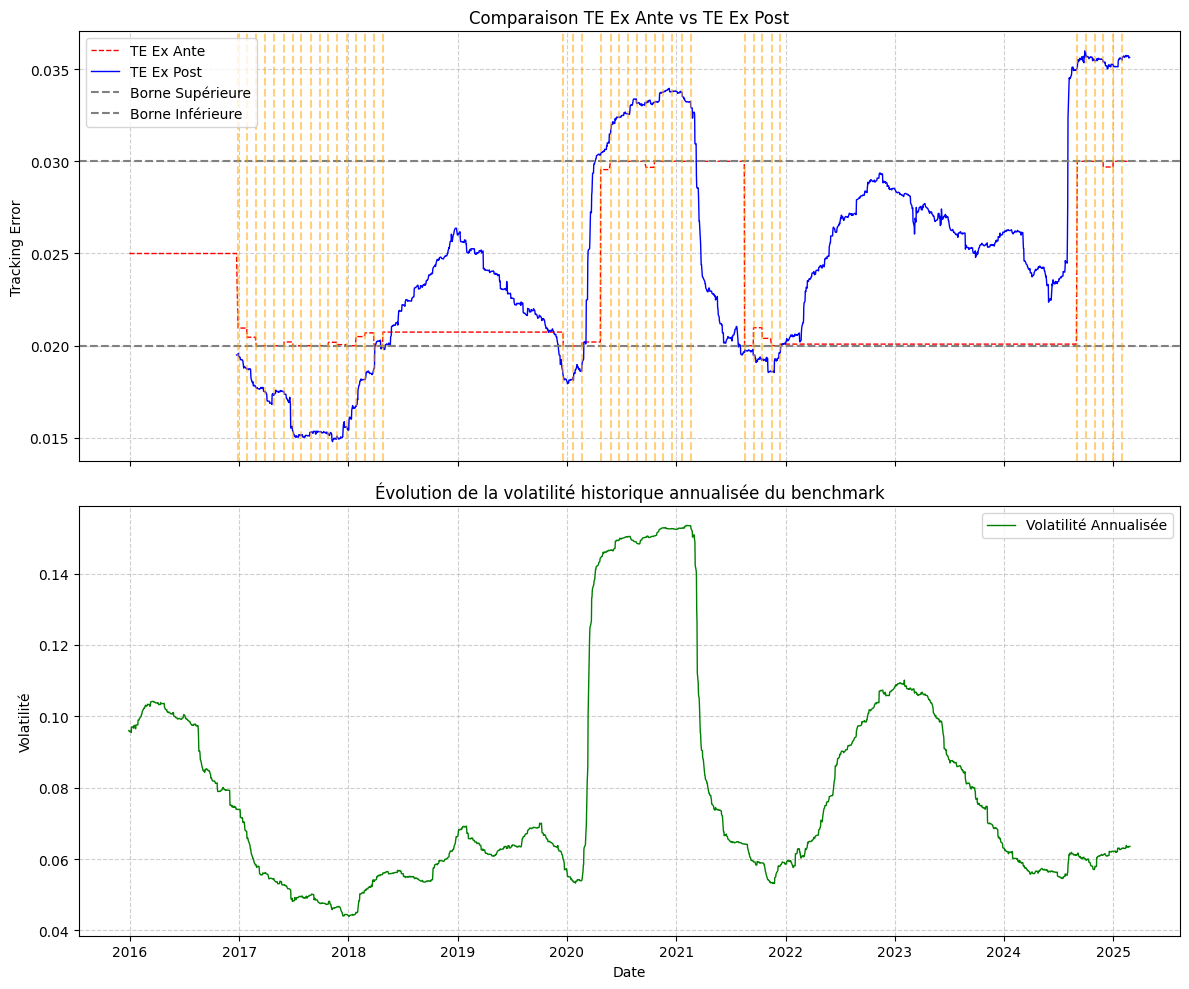

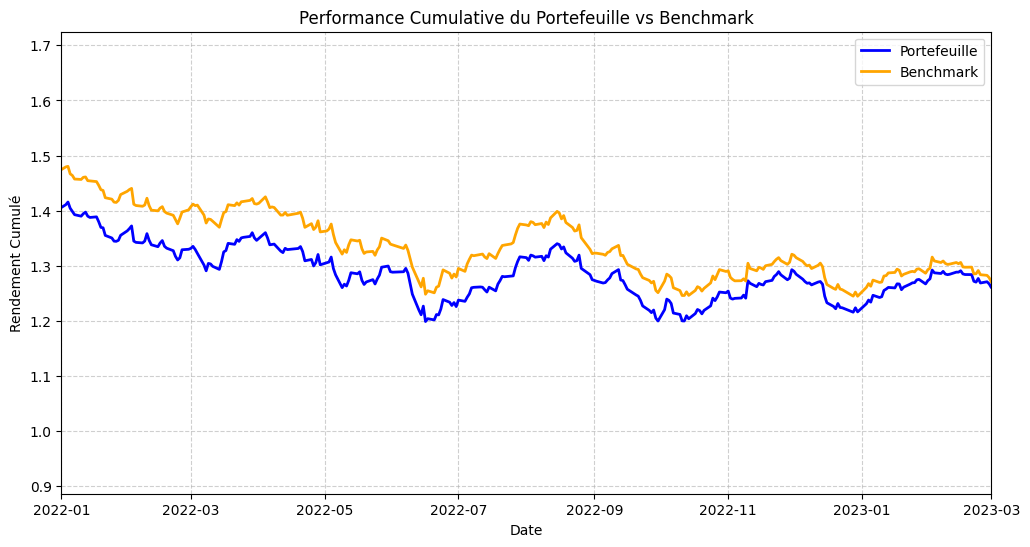

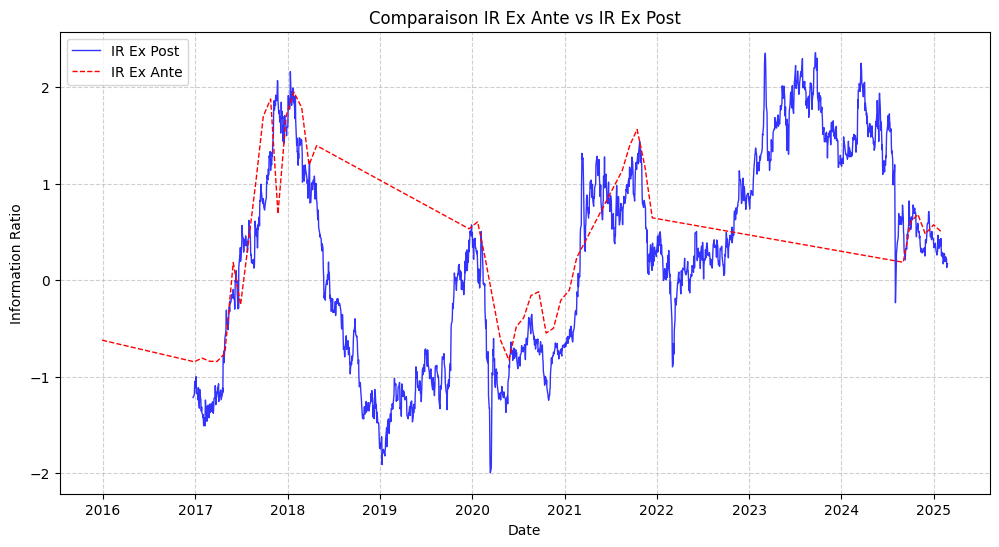

<Figure size 1200x600 with 0 Axes>

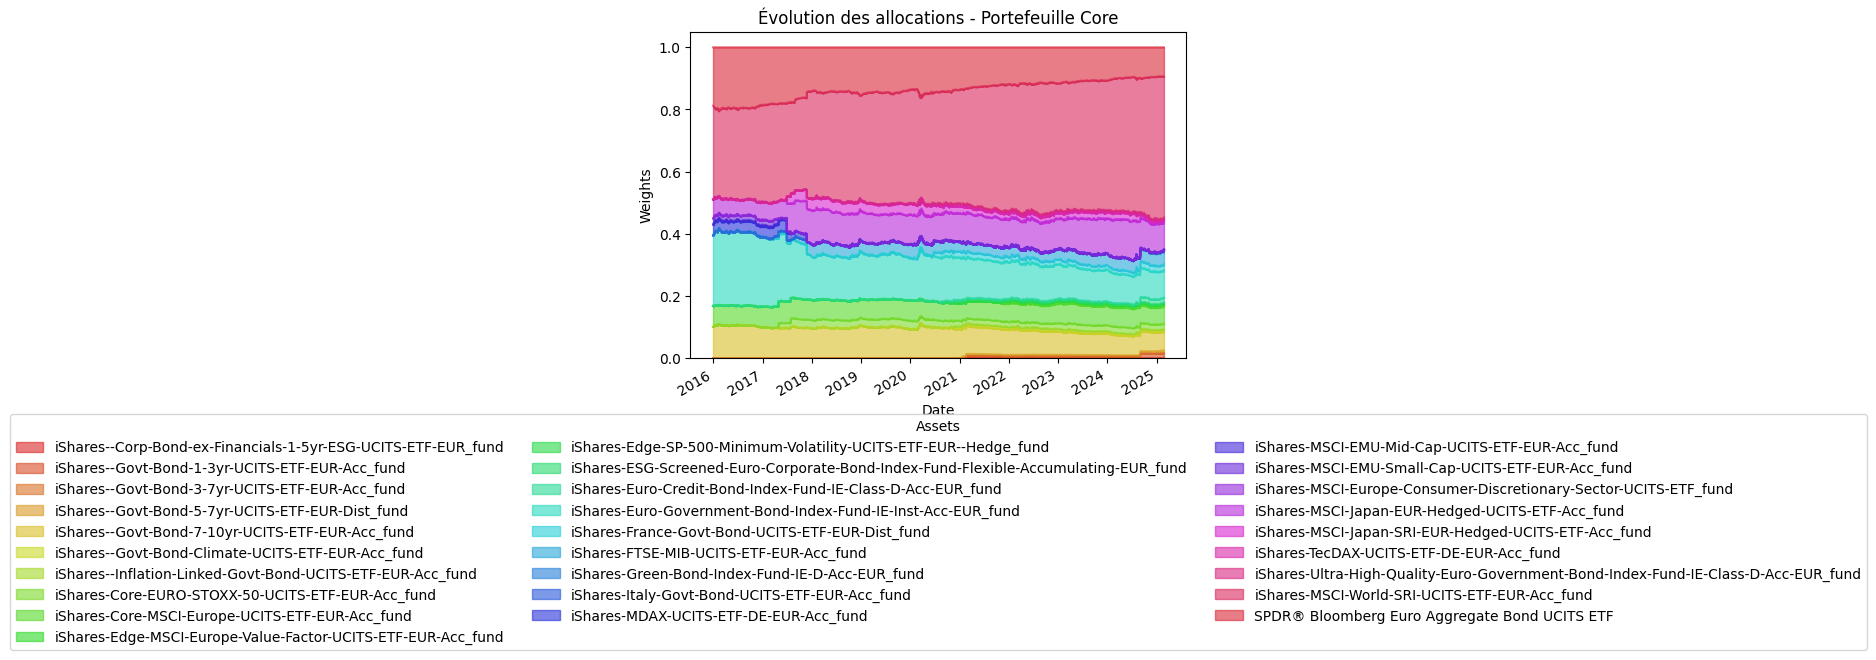

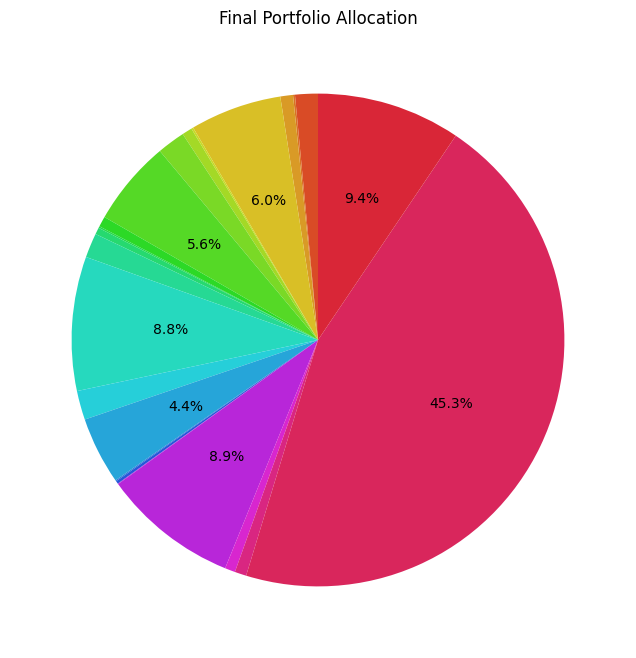

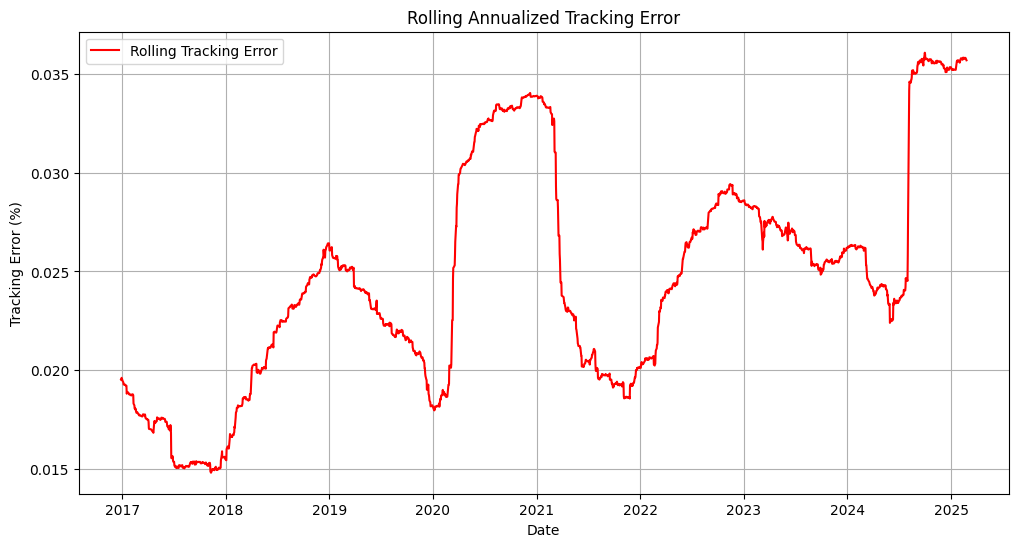

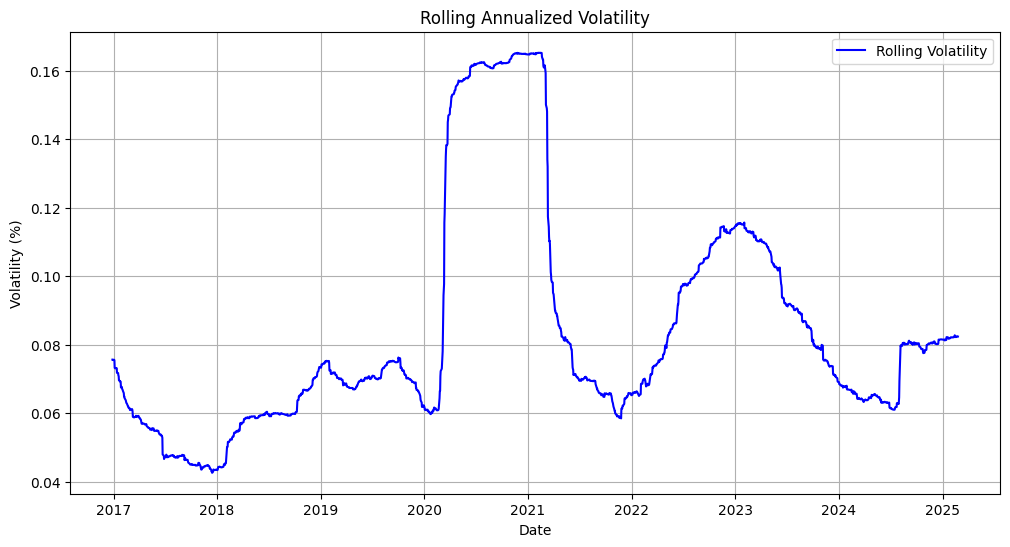

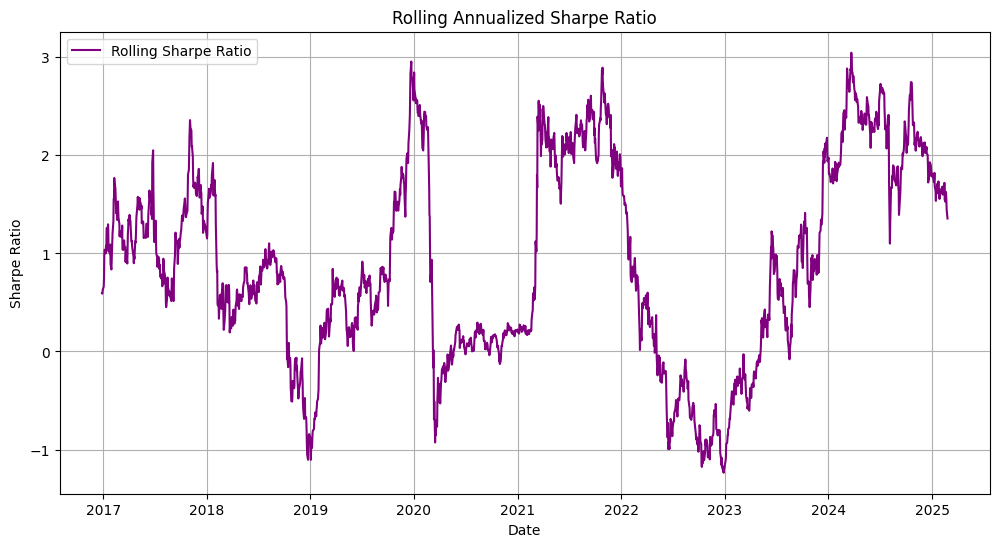

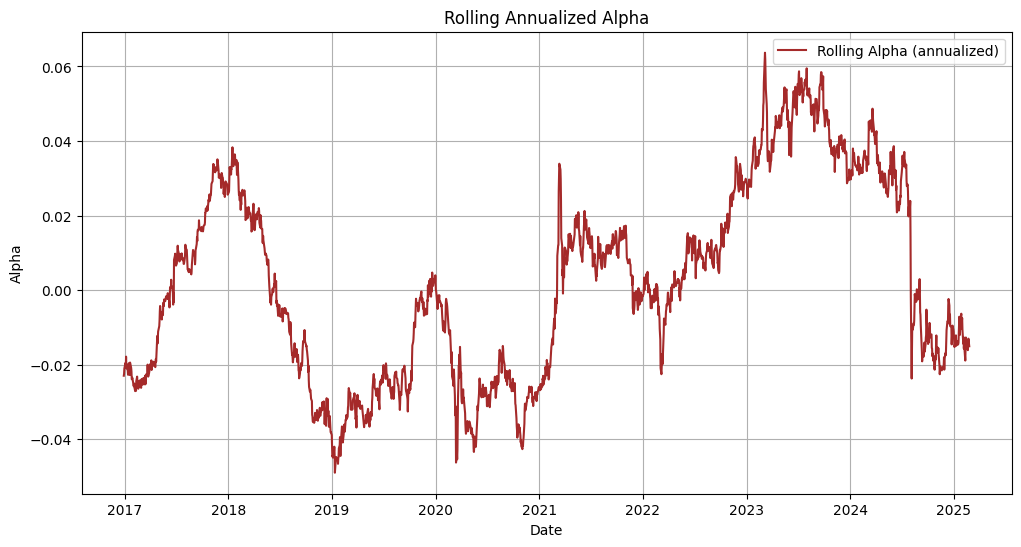

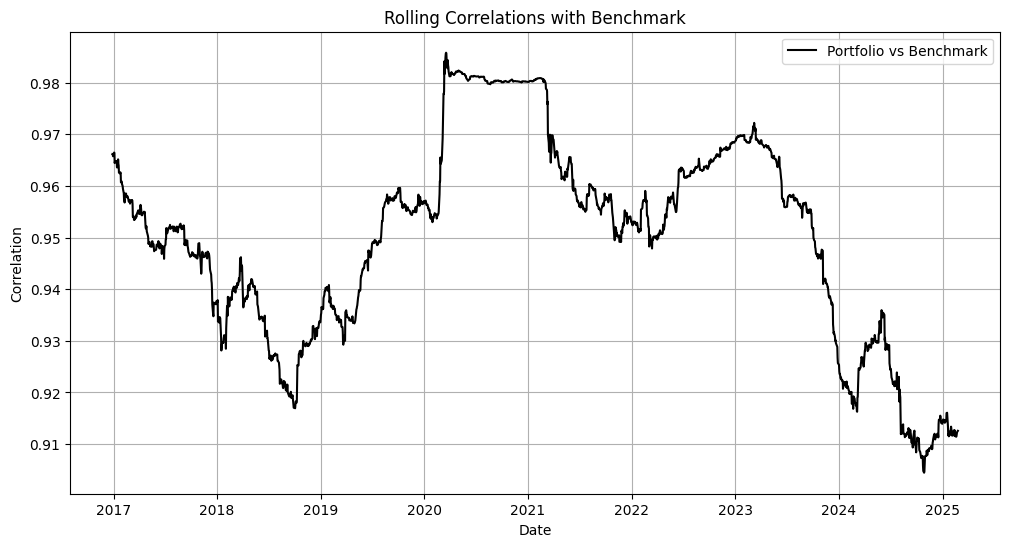

                       Metric     Value
        Annualized Volatility  0.089450
             Maximum Drawdown -0.223236
    Annualized Tracking Error  0.025609
Corr (Portfolio vs Benchmark)  0.958992
     Corr (Core vs Benchmark)       NaN
Corr (Satellite vs Benchmark)       NaN
          Global Sharpe Ratio  0.662179
    Global Alpha (annualized)       NaN
Correlation Matrix:
           Portfolio  Benchmark
Portfolio   1.000000   0.958992
Benchmark   0.958992   1.000000
Frais annuels moyens supportés : 0.2362%


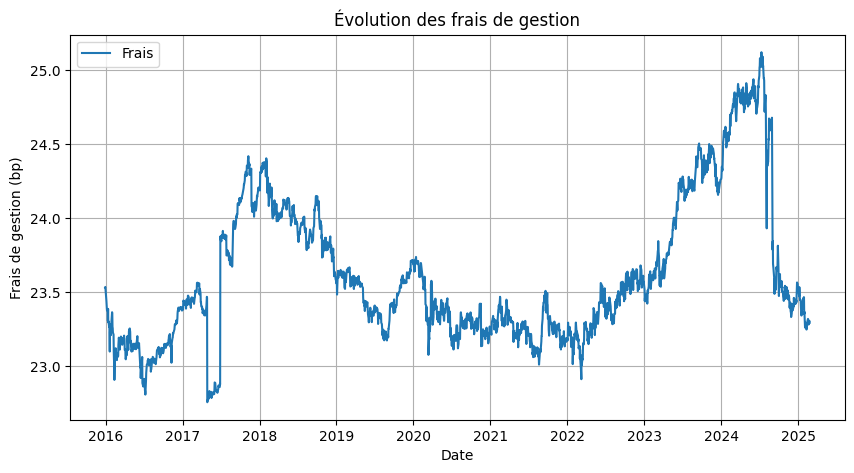

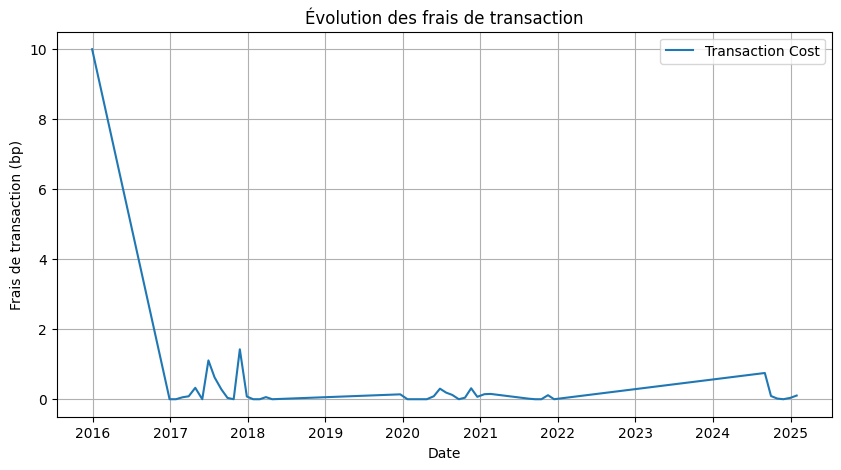

In [13]:
# Creation of a Series of fees with null values for each asset.
fee_rate = pd.Series(0.0010, index=universe_returns_aligned.columns)


# Filtering from a given date
start_date = pd.Timestamp("2015-01-01")
universe_returns_aligned = universe_returns_aligned[universe_returns_aligned.index >= start_date] #rendements nets de frais
benchmark_returns_aligned = benchmark_returns_aligned[benchmark_returns_aligned.index >= start_date]

#Optimization ---------------------------------------------------------------------------------------------------------------
# Parameters
objective_threshold = 0.025  # Target tracking error (TE)
rolling_window = 252
rebalance_freq_core = 21 # Rebalance every 21 days (Monthly)
objective_function = Utilities.information_ratio_ex_ante
te_tolerance = 0.005 # Tolerance for tracking error (TE) in the optimization process

fee_rate_core_sim = fee_rate  

# Initialize the backtester
BacktesterPort = Backtester(
    universe_returns_aligned,
    benchmark_returns_aligned,
    objective_function,
    objective_threshold,
    fee_rate_core = fee_rate_core_sim,
    te_tolerance=te_tolerance
)

# Call the optimized Core function.
result = BacktesterPort.optimize_allocation_portfolio(rolling_window=rolling_window, 
                                                  rebalance_freq_core=rebalance_freq_core, 
                                                  core_portfolio_weight=1, 
                                                  te_tolerance=te_tolerance,
                                                  verbose=True)

# Unpacking the results.
(core_returns_series,allocations_core_df,rebalancing_dates,
IR_core_ex_ante_df, IR_core_ex_post_df, TE_core_ex_ante_df, TE_core_ex_post_df, 
transaction_costs_core_df) = result

# Visualisation ---------------------------------------------------------------------------------------------------------------

# Compute the cumulative returns
cumulative_benchmark_returns = (1 + benchmark_returns_aligned.loc[core_returns_series.index]).cumprod()
cumulative_core_returns = (1 + core_returns_series).cumprod()

# Create a visualizer object
visualisation = Visualizer(cumulative_core_returns)

benchmark_returns_plot,universe_returns_aligned = Utilities.align_dataframes(benchmark_returns, universe_returns_aligned)

# visualisation.plot_universe_cumulative_performance_by_asset_type(
#     universe_returns_aligned,
#     benchmark_returns_plot,
#     custom_title_bonds="Performance Cumulée - ETFs Bonds vs LBEATREU",
#     custom_title_equity="Performance Cumulée - ETFs Actions vs MSCI_WORLD"
# )

# 1. Graph of cumulative performance of the core portfolio vs benchmark.
visualisation.plot_cumulative_performance_core(
    cumulative_core_returns, 
    cumulative_benchmark_returns, 
    title="Cumulative Performance of the Optimized Portfolio (Information Ratio Maximization) vs. Benchmark", 
)

# 2. Graph of Tracking Error (ex ante vs ex post) for the core section.
visualisation.plot_tracking_errors(
    TE_core_ex_ante_df, 
    TE_core_ex_post_df, 
    te_target=objective_threshold, 
    te_tolerance=te_tolerance, 
    start_day=1
)

visualisation.plot_tracking_errors_evol(
    TE_core_ex_ante_df, 
    TE_core_ex_post_df, 
    te_target=objective_threshold, 
    te_tolerance=te_tolerance,
    rebalancing_dates = rebalancing_dates, 
    benchmark_returns_aligned = benchmark_returns_aligned,
    vol_window = 252,
    start_day=1
)

visualisation.plot_cumulative_returns_zoom(cumulative_core_returns, cumulative_benchmark_returns, zoom_start="2022-01-01", zoom_end="2023-03-01")


# 3. Graph of the Information Ratio for the core section (ex ante vs ex post).
visualisation.plot_IR(IR_core_ex_ante_df, IR_core_ex_post_df)  

# 4. Graphs of the evolution of allocations.
asset_invested = visualisation.plot_allocations_evolution_3(
    allocations_core_df, 
    optimization_type="maxir", 
    custom_title="Évolution des allocations - Portefeuille Core"
)

benchmark_series_visu = benchmark_returns_aligned
core_returns_series_visu,benchmark_series_visu = Utilities.align_dataframes(core_returns_series,benchmark_series_visu)

visualisation.calculate_stats(core_returns_series, benchmark_series_visu, window=252)

# 5. Graph of the evolution of the weights of the assets in the portfolio.
daily_management_fees = Utilities.calculate_management_fees(allocations_core_df, fees_df)
visualisation.plot_costs_in_bp(daily_management_fees, title="Évolution des frais de gestion", xlabel="Date", ylabel="Frais de gestion (bp)", linestyle='-',annualized=True)
visualisation.plot_costs_in_bp(transaction_costs_core_df, title="Évolution des frais de transaction", xlabel="Date", ylabel="Frais de transaction (bp)", linestyle='-')




# Partie 4 : Construction du portefeuille Satellite

- #### Partie 4.1 : Construction de la poche "Sélection Qualitative" du portefeuille Satellite

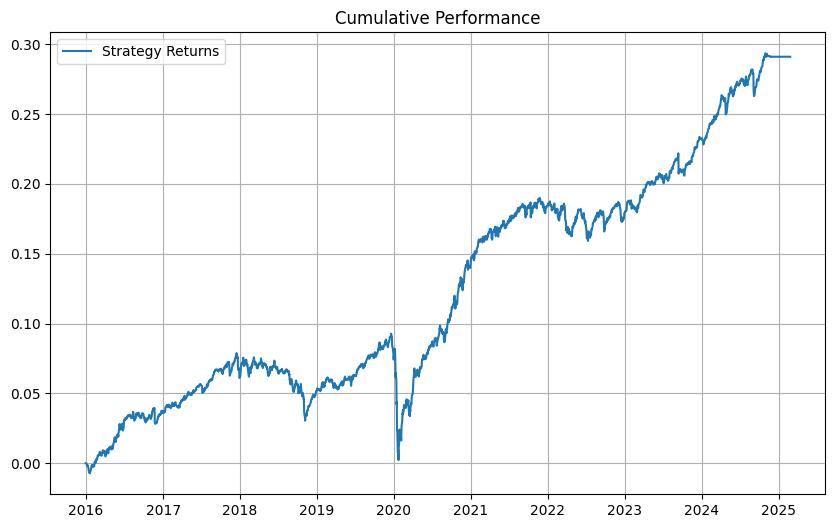

Performance metrics:
total_return: 0.29101200036375685
annualized_return: 0.027949829364343648
volatility: portfolio_returns    0.026726
dtype: float64
sharpe_ratio: portfolio_returns    1.045776
dtype: float64
max_drawdown: portfolio_returns   -inf
dtype: float64


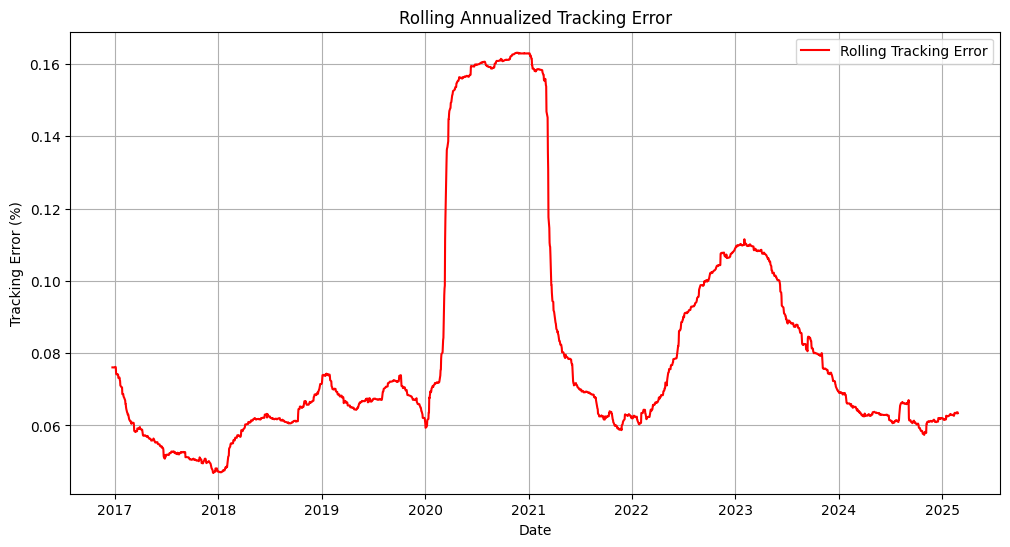

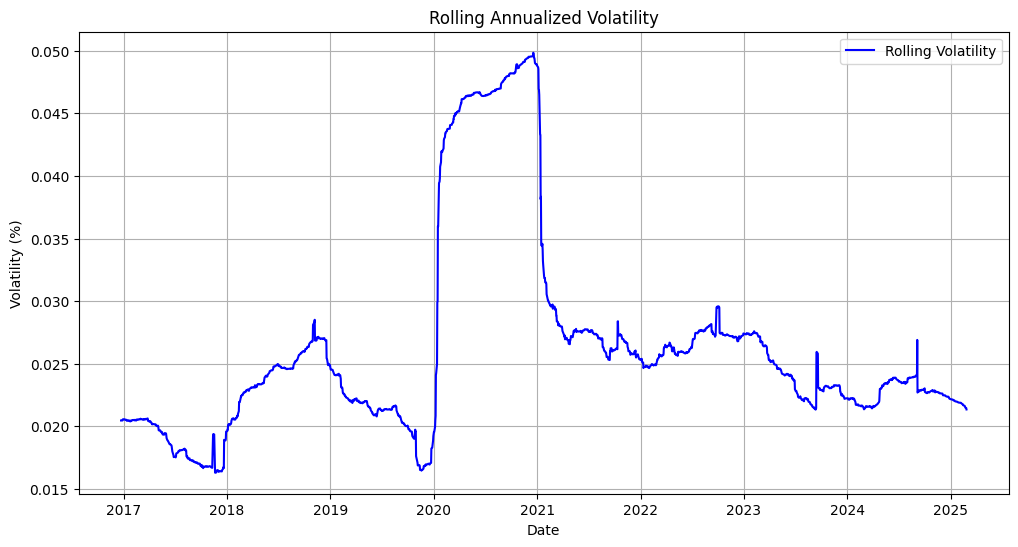

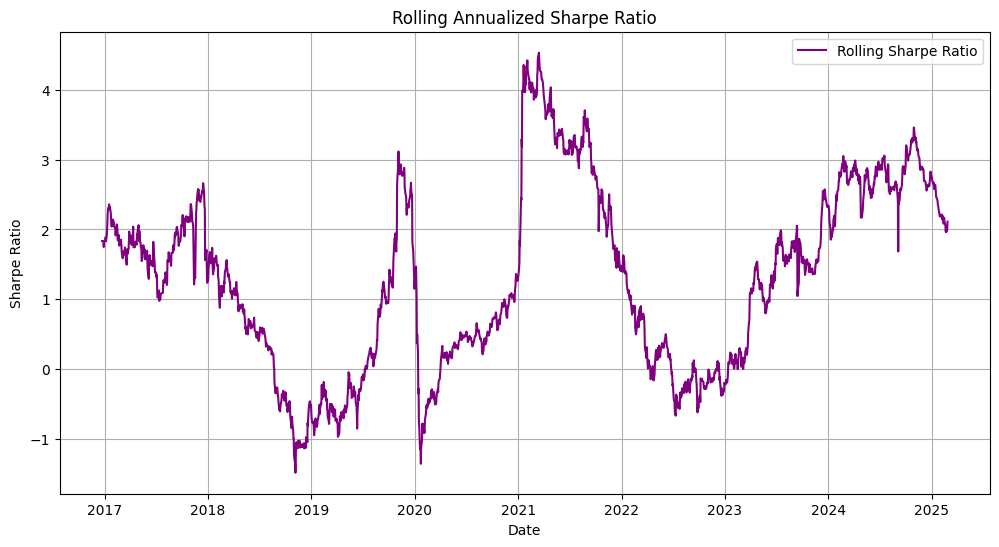

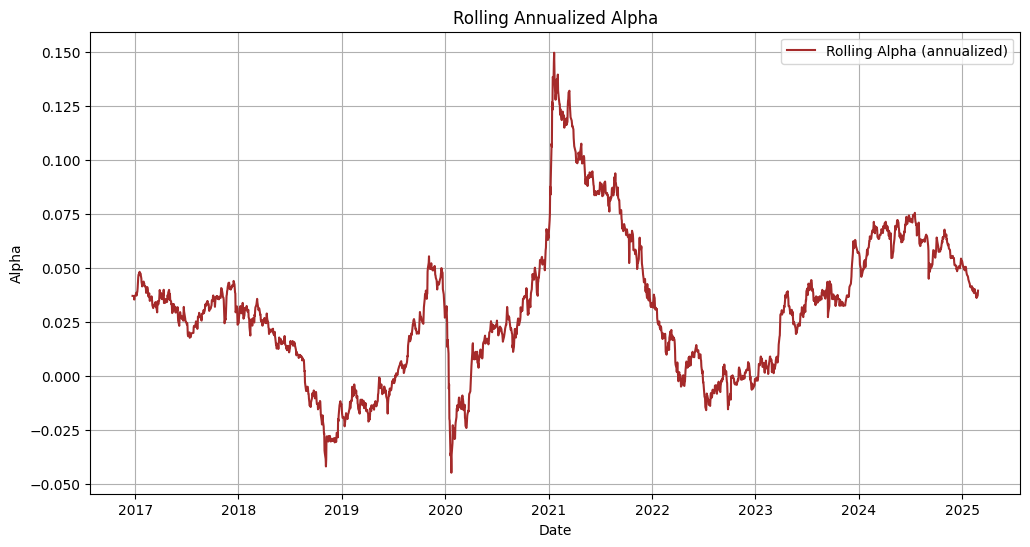

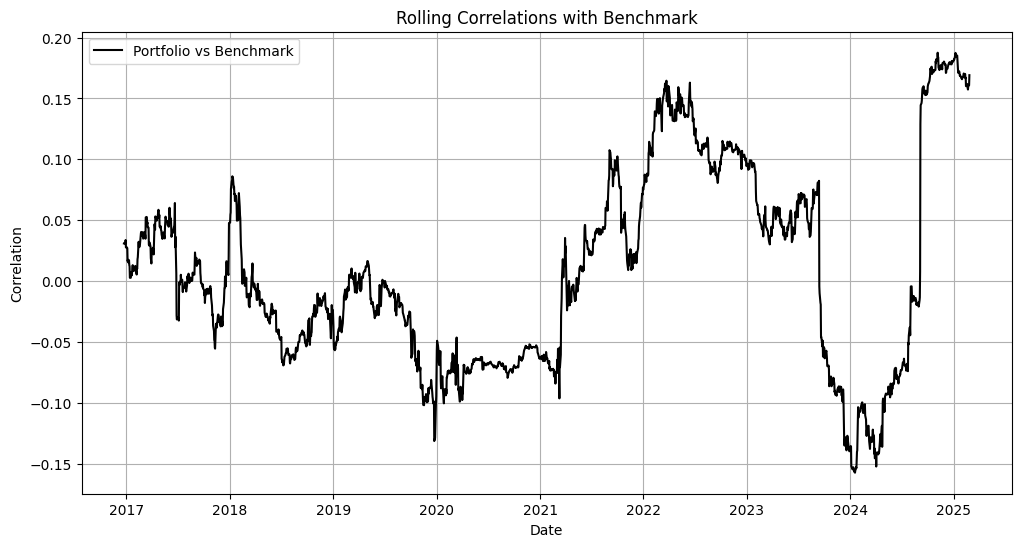

                       Metric     Value
        Annualized Volatility  0.026726
             Maximum Drawdown -0.087058
    Annualized Tracking Error  0.086304
Corr (Portfolio vs Benchmark)  0.000198
     Corr (Core vs Benchmark)       NaN
Corr (Satellite vs Benchmark)       NaN
          Global Sharpe Ratio  1.175125
    Global Alpha (annualized)  0.031403
Correlation Matrix:
           Portfolio  Benchmark
Portfolio   1.000000   0.000198
Benchmark   0.000198   1.000000


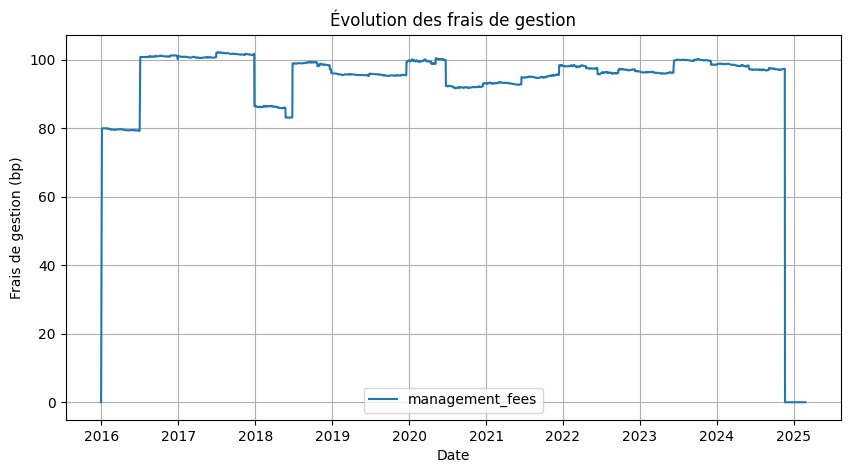

In [5]:
def run_example_backtest(data_path, file_name, sheet_name="data"):
    """ Run an example backtest of a buy and hold strategy """

    # Configure data source
    data_source = ExcelDataSource(file_path=f"{data_path}\\{file_name}.xlsx", sheet_name=sheet_name)

    # Loading, cleaning and preprocessing data
    data_manager = DataManager(data_source=data_source)
    data_manager.load_data()
    data_manager.clean_data()
    data_manager.compute_returns()

    # Creating the strategy
    strategy = BuyAndHold(data_manager.returns)
    signals = strategy.compute_signals()

    # Portfolio construction
    portfolio = NaiveRiskParity(data_manager.returns, signals, portfolio_type="long_only", rebal_periods=rebal_periods)
    weights = portfolio.rebalance_portfolio()

    # Backtesting
    backtest = Backtest(data_manager.returns.shift(-1), weights, rebal_periods=rebal_periods, transaction_cost_bps=tc_bps)
    strategy_returns = backtest.run_backtest()

    # Compute management fees
    daily_management_fees = backtest.compute_management_fees()

    # Analyse the backtest results
    analyzer = PerformanceAnalyser(strategy_returns)
    analyzer.compute_cumulative_performance()
    analyzer.compute_equity_curve()
    metrics = analyzer.compute_metrics()

    # Visualisation
    visualizer = Visualizer(analyzer)
    visualizer.plot_cumulative_performance()

    return {
        'data': data_manager,
        'strategy': strategy,
        'portfolio': portfolio,

        'weights': weights,
        'assets_returns': data_manager.returns,

        'returns': strategy_returns,
        'metrics': metrics,
        'management fees': daily_management_fees
    }

# Usage example
rebal_periods = 21*6
tc_bps = 5
results = run_example_backtest(
    data_path="data",
    file_name="data_ETFs_funds_final",
    sheet_name="data"
)

# putting results into variables
weights_sat_qual = results['weights']
assets_returns_sat_qual = results['assets_returns']
returns_sat_qual = results['returns']
qual_management_fees = results['management fees']

print("Performance metrics:")
for key, value in results['metrics'].items():
    print(f"{key}: {value}")

# stats
benchmark_series_aligned,rendements_aligned_sat_quant = Utilities.align_dataframes(combined_benchmark, returns_sat_qual)
visualisation.calculate_stats(returns_sat_qual, benchmark_series_aligned, window=252)
visualisation.plot_costs_in_bp(qual_management_fees, title="Évolution des frais de gestion", xlabel="Date", ylabel="Frais de gestion (bp)", linestyle='-',annualized=True)

- #### Partie 4.2 : Construction de la poche "Quantitative" du portefeuille Satellite


MSCI MOMENTUM  MSCI VALUE  MSCI QUALITY  MSCI WORLD     ETF MOM  \
Dates                                                                         
2015-11-03     100.000000  100.000000    100.000000  100.000000  100.000000   
2015-11-04     100.014203   99.819758     99.887703   99.809082  100.627565   
2015-11-05     100.737895   99.560281     99.558390   99.649176  100.579290   
2015-11-06     100.300839   99.172683     99.161144   99.287642  101.472363   
2015-11-09      99.916075   98.423476     98.184112   98.554790  100.603427   
...                   ...         ...           ...         ...         ...   
2025-02-19     328.934151  204.763149    241.206987  261.048044  339.850350   
2025-02-20     325.612653  204.763149    241.206987  261.048044  333.526430   
2025-02-21     320.175597  204.763149    241.206987  261.048044  333.816075   
2025-02-24     317.990962  204.763149    241.206987  261.048044  328.119720   
2025-02-25     316.449322  204.763149    241.206987  261.048044  321.892349   

             ETF VALUE  ETF QUALITY   ETF WORLD  relatif Momentum  \
Dates                                                               
2015-11-03  100.000000   100.000000  100.000000          1.000000   
2015-11-04  100.677744   100.657895  100.751393          1.002055   
2015-11-05  100.306078   100.226151  100.401606          1.010926   
2015-11-06  100.896371   100.925164  101.036404          1.010205   
2015-11-09  100.153039    99.814967   99.961135          1.013812   
...                ...          ...         ...               ...   
2025-02-19  199.169217   290.172697  281.979531          1.260052   
2025-02-20  198.710101   288.281250  279.207151          1.247328   
2025-02-21  198.972453   288.486842  279.440342          1.226501   
2025-02-24  197.813730   286.348684  276.305221          1.218132   
2025-02-25  197.791867   283.018092  272.133696          1.212226   

            relatif Value  relatif Quality  
Dates                                       
2015-11-03       1.000000         1.000000  
2015-11-04       1.000107         1.000788  
2015-11-05       0.999108         0.999089  
2015-11-06       0.998842         0.998726  
2015-11-09       0.998668         0.996239  
...                   ...              ...  
2025-02-19       0.784389         0.923995  
2025-02-20       0.784389         0.923995  
2025-02-21       0.784389         0.923995  
2025-02-24       0.784389         0.923995  
2025-02-25       0.784389         0.923995  

[2374 rows x 11 columns]

c:\Users\theod\OneDrive\Bureau\Theo\Master IEF Dauphine\S2\Cross Asset investments solution\ppt\Meyer_Molinaro_Khadir_Domingues\Meyer_Molinaro_Khadir_Domingues\modules\my_packages\strategy.py:160: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_signal = self.df[self.signal_cols].resample('M').last()  # on prend les derniers prix chaque mois
C:\Users\theod\AppData\Local\Temp\ipykernel_18848\1115731916.py:26: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  benchmark_cumulative_returns_reindex = benchmark_cumulative_returns.reindex(rendements.index).pct_change()


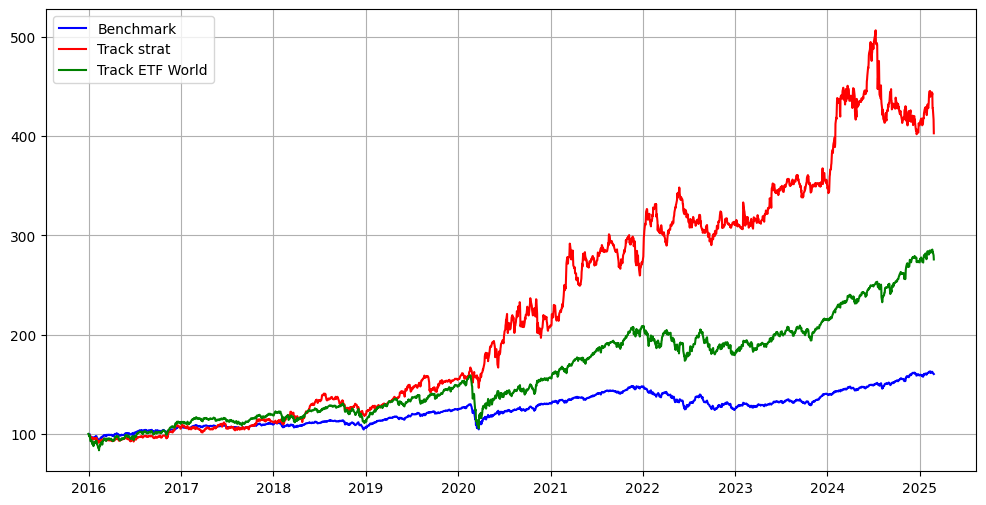

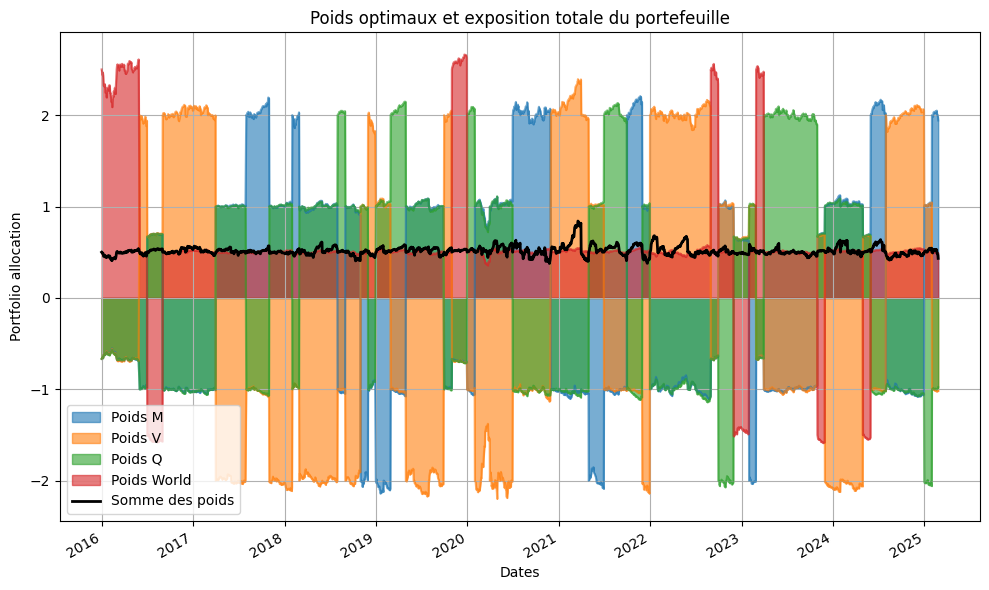

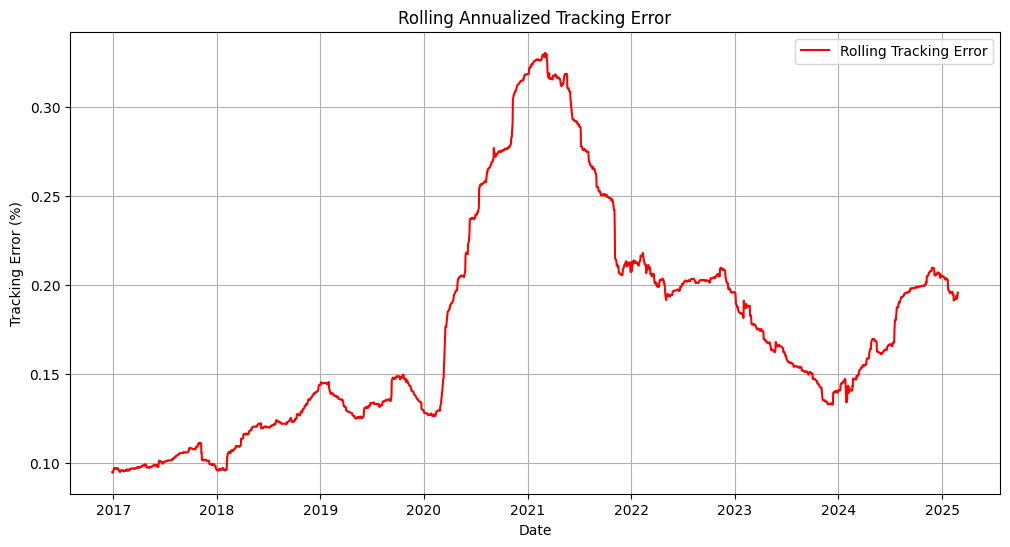

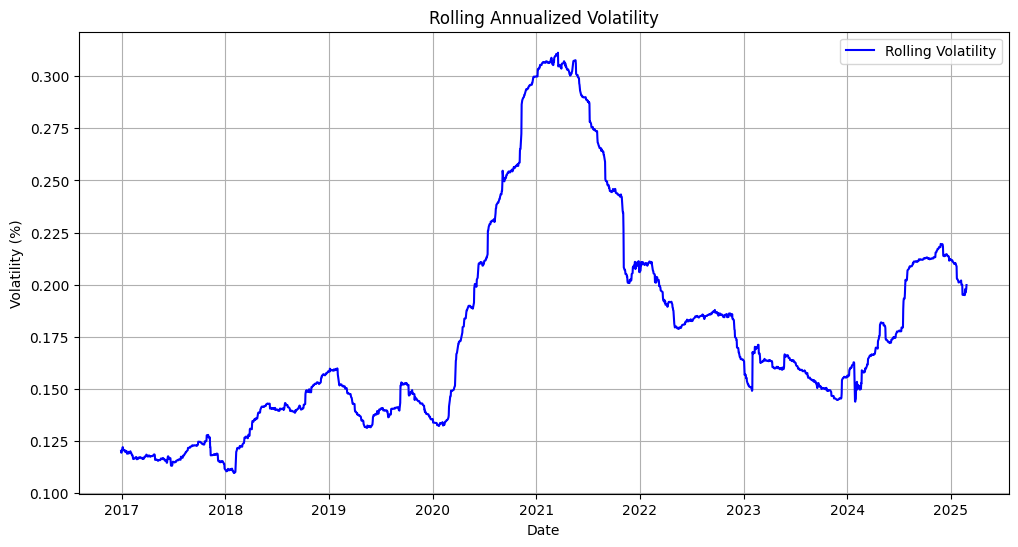

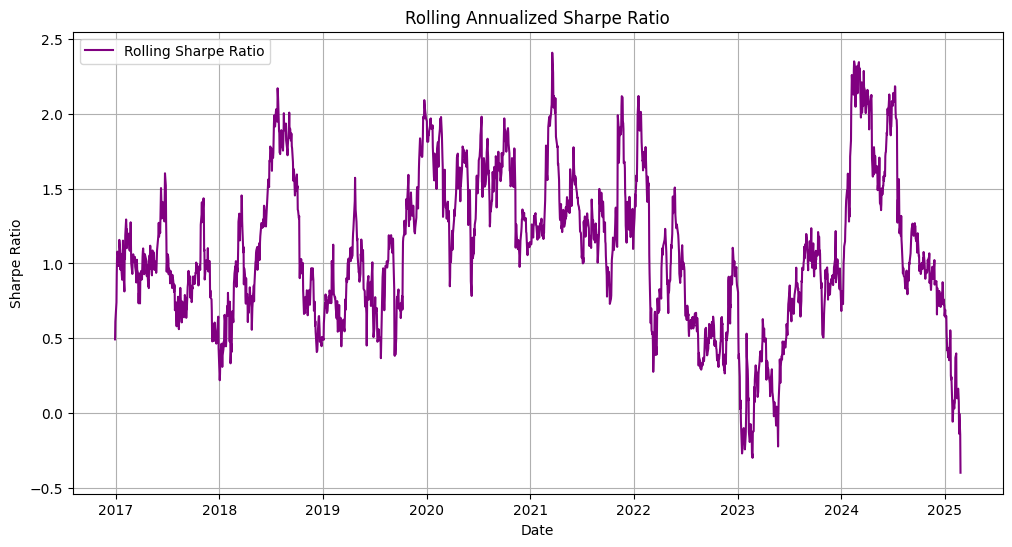

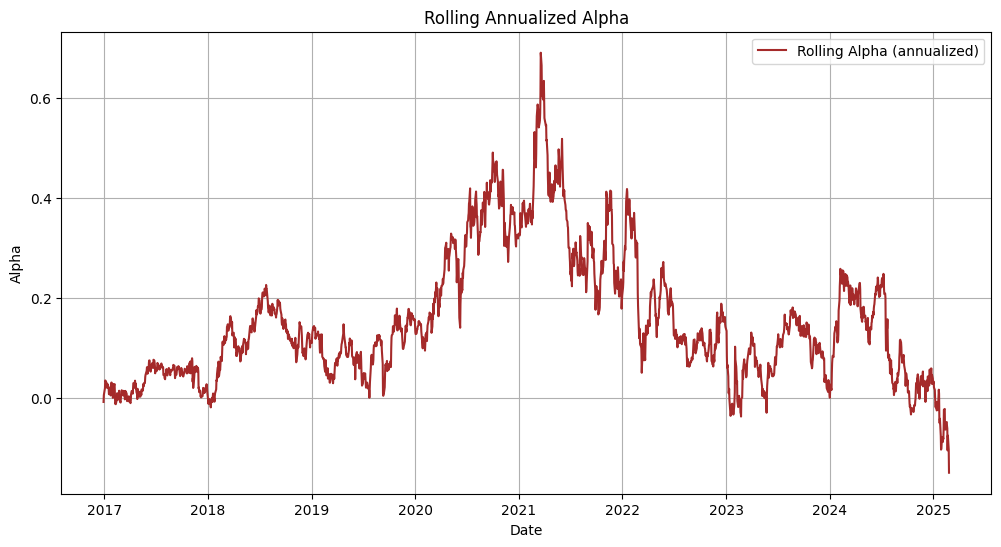

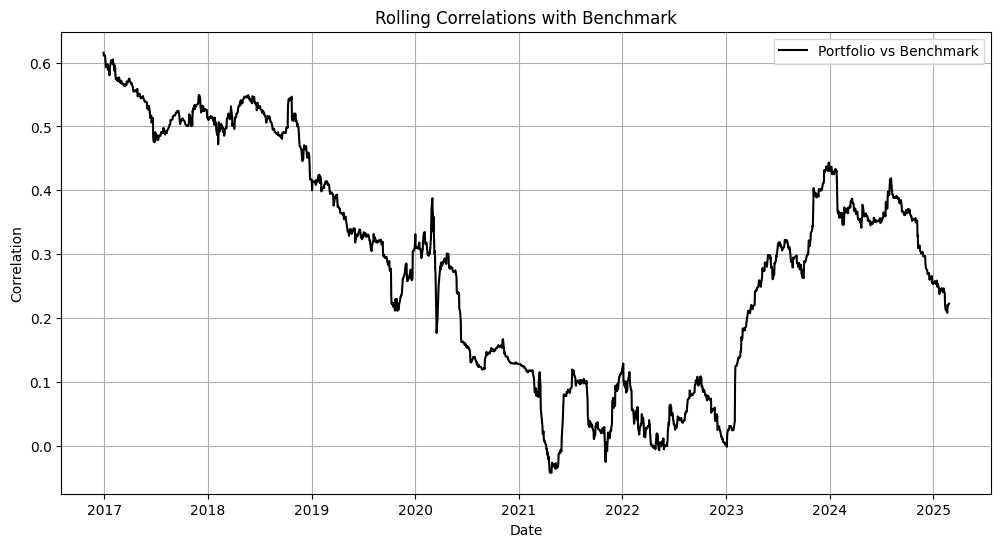

                       Metric     Value
        Annualized Volatility  0.182517
             Maximum Drawdown -0.206748
    Annualized Tracking Error  0.182871
Corr (Portfolio vs Benchmark)  0.220586
     Corr (Core vs Benchmark)       NaN
Corr (Satellite vs Benchmark)       NaN
          Global Sharpe Ratio  0.916521
    Global Alpha (annualized)       NaN
Correlation Matrix:
           Portfolio  Benchmark
Portfolio   1.000000   0.220586
Benchmark   0.220586   1.000000


In [6]:
excel_path_quant = os.path.join(BASE_DIR, "data", "Data_satellite_quant.xlsx")

# Create an ExcelDataSource object
df = ExcelDataSource(file_path=excel_path_quant, sheet_name='Data Facteurs', index_col=0).fetch_data_core()
#df = pd.read_excel('classeur999.xlsx',sheet_name='Data Facteurs',index_col=0)
df['relatif Momentum'] = df['MSCI MOMENTUM'] / df['MSCI WORLD']
df['relatif Value'] = df['MSCI VALUE'] / df['MSCI WORLD']
df['relatif Quality'] = df['MSCI QUALITY'] / df['MSCI WORLD']
display(df)

strat = FactorStrategy(df, signal_cols=['relatif Momentum', 'relatif Value', 'relatif Quality'],window=6,max_lvg_factor=2)

# Étapes du pipeline
strat.generate_signals()
strat.generate_weights()
strat.build_daily_weights()
results = strat.compute_performance()

# résultats
df_resultats = results['DataFrame Stratégie']
poids = results['Poids facteurs']
rendements = results['return strat']

#Affichage des performances
plt.figure(figsize=(12,6))
benchmark_cumulative_returns_reindex = benchmark_cumulative_returns.reindex(rendements.index).pct_change()
benchmark_cumulative_returns_reindex = 100*(1+benchmark_cumulative_returns_reindex).cumprod()

plt.plot(benchmark_cumulative_returns_reindex.index, benchmark_cumulative_returns_reindex, label="Benchmark", color="blue")
plt.plot(df_resultats['Track strat'], label='Track strat', color='red')
plt.plot(df_resultats['Track ETF World'], label='Track ETF World', color='green')
plt.legend()
plt.grid(True)
plt.show()

# Tracer les poids 
ax = poids.plot(kind='area', figsize=(10, 6), stacked=False, alpha=0.6)
poids.sum(axis=1).plot(ax=ax, color='black', linewidth=2, label='Somme des poids')
plt.title('Poids optimaux et exposition totale du portefeuille')
plt.ylabel('Portfolio allocation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


benchmark_series = combined_benchmark
benchmark_series_aligned,rendements_aligned_sat_quant = Utilities.align_dataframes(benchmark_series,rendements)
visualisation.calculate_stats(rendements_aligned_sat_quant, benchmark_series_aligned, window=252)

- #### Partie 4.3 : Optimisation du portefeuille Satellite, avec la poche "Sélection" et la poche "Quantitative"


Ex-post volatility (annualized): 0.0871
Rebalancing triggered: realized volatility 0.0871 is outside the target bounds [0.1300, 0.1700]
Ex-post volatility (annualized): 0.0878
Rebalancing triggered: realized volatility 0.0878 is outside the target bounds [0.1300, 0.1700]
Ex-post volatility (annualized): 0.0885
Rebalancing triggered: realized volatility 0.0885 is outside the target bounds [0.1300, 0.1700]
Ex-post volatility (annualized): 0.0896
Rebalancing triggered: realized volatility 0.0896 is outside the target bounds [0.1300, 0.1700]
Ex-post volatility (annualized): 0.0912
Rebalancing triggered: realized volatility 0.0912 is outside the target bounds [0.1300, 0.1700]
Ex-post volatility (annualized): 0.0912
Rebalancing triggered: realized volatility 0.0912 is outside the target bounds [0.1300, 0.1700]
Ex-post volatility (annualized): 0.0912
Rebalancing triggered: realized volatility 0.0912 is outside the target bounds [0.1300, 0.1700]
Ex-post volatility (annualized): 0.0918
Rebalanc

c:\Users\theod\OneDrive\Bureau\Theo\Master IEF Dauphine\S2\Cross Asset investments solution\ppt\Meyer_Molinaro_Khadir_Domingues\Meyer_Molinaro_Khadir_Domingues\modules\my_packages\strategy.py:482: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  core_weights.fillna(method='ffill', inplace=True)
c:\Users\theod\OneDrive\Bureau\Theo\Master IEF Dauphine\S2\Cross Asset investments solution\ppt\Meyer_Molinaro_Khadir_Domingues\Meyer_Molinaro_Khadir_Domingues\modules\my_packages\strategy.py:484: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  semi_vol_series.fillna(method='ffill', inplace=True)
c:\Users\theod\OneDrive\Bureau\Theo\Master IEF Dauphine\S2\Cross Asset investments solution\ppt\Meyer_Molinaro_Khadir_Domingues\Meyer_Molinaro_Khadir_Domingues\modules\my_packages\strategy.py:485: FutureWarning: Series.fillna with 'm

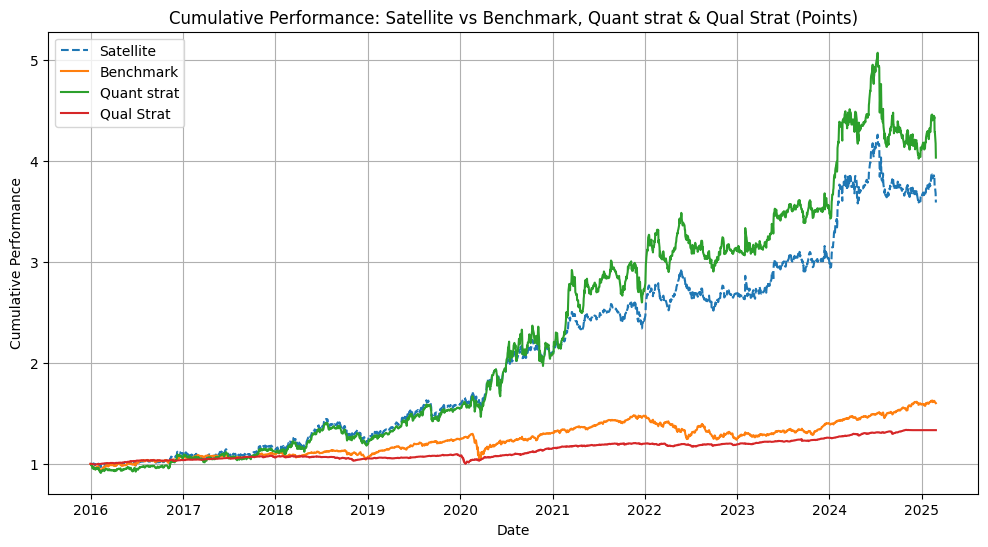

<Figure size 1200x600 with 0 Axes>

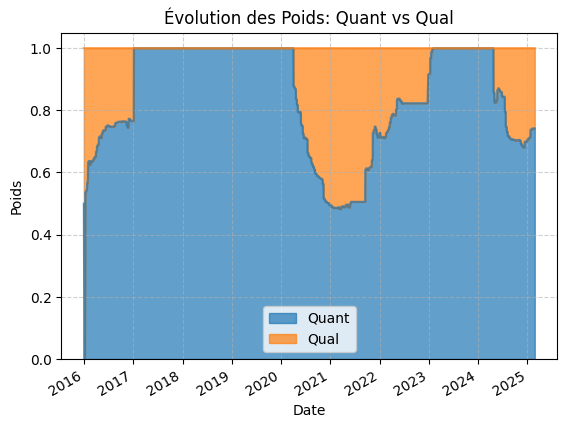

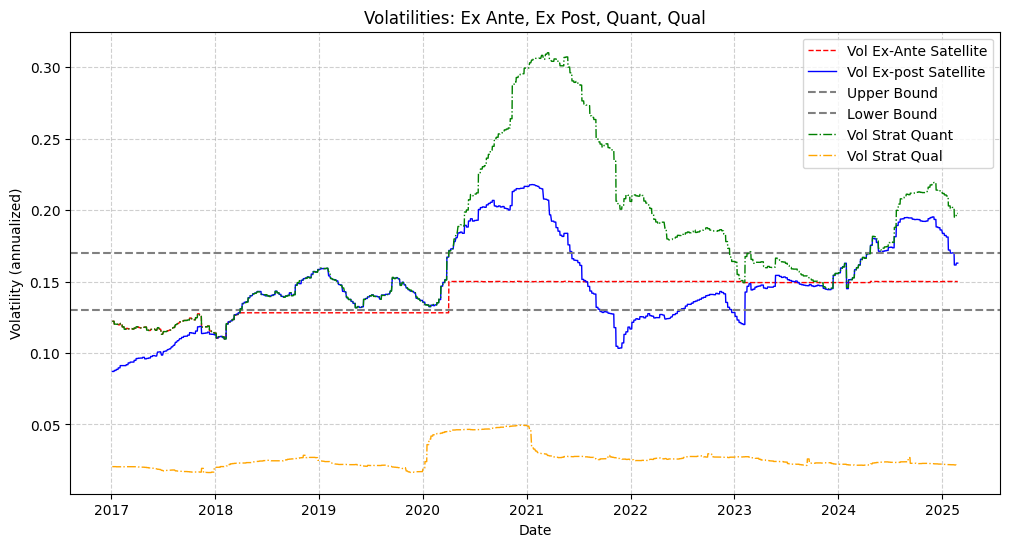

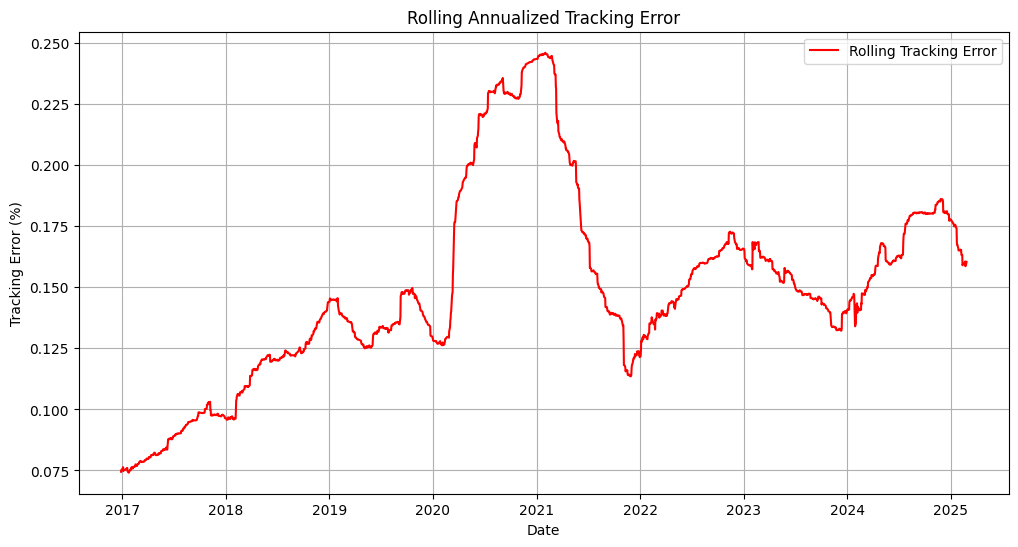

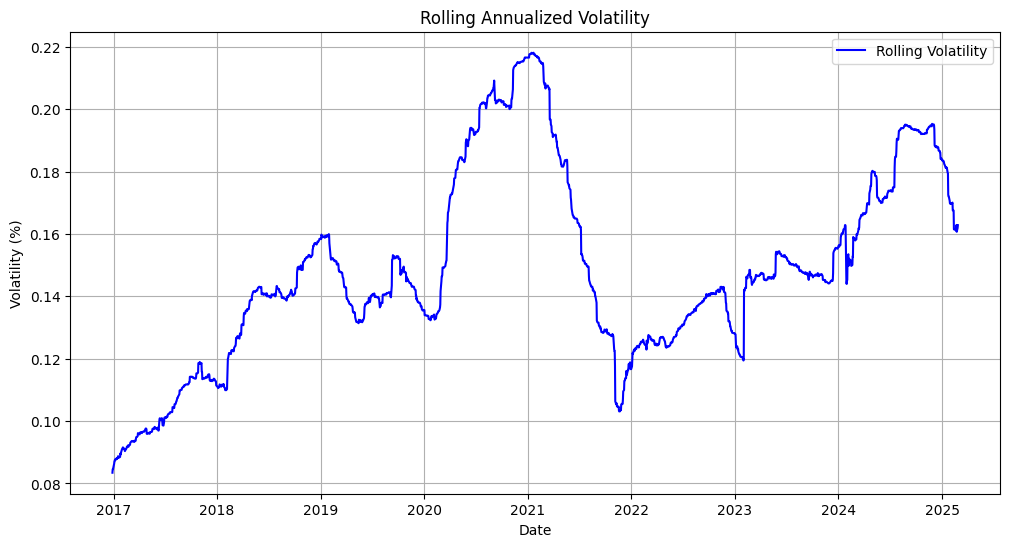

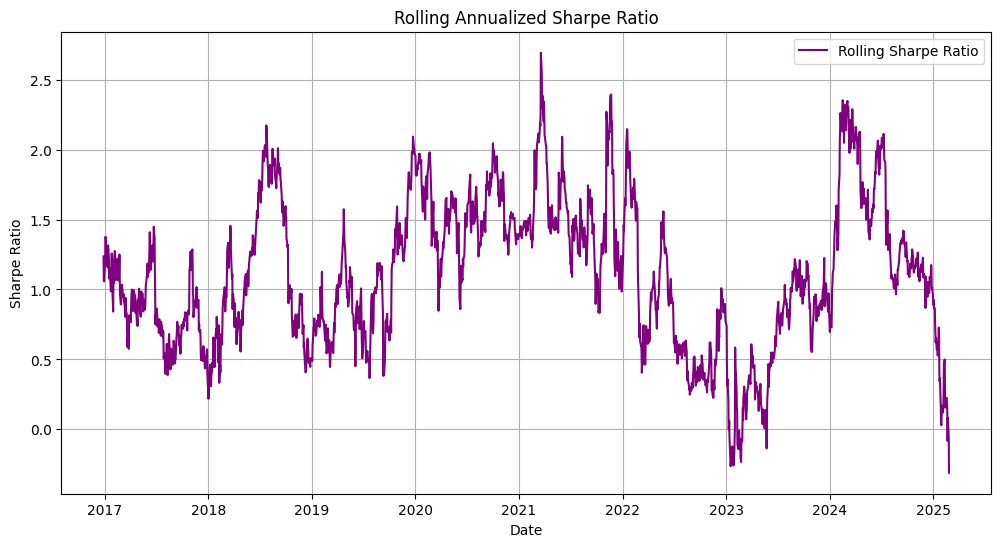

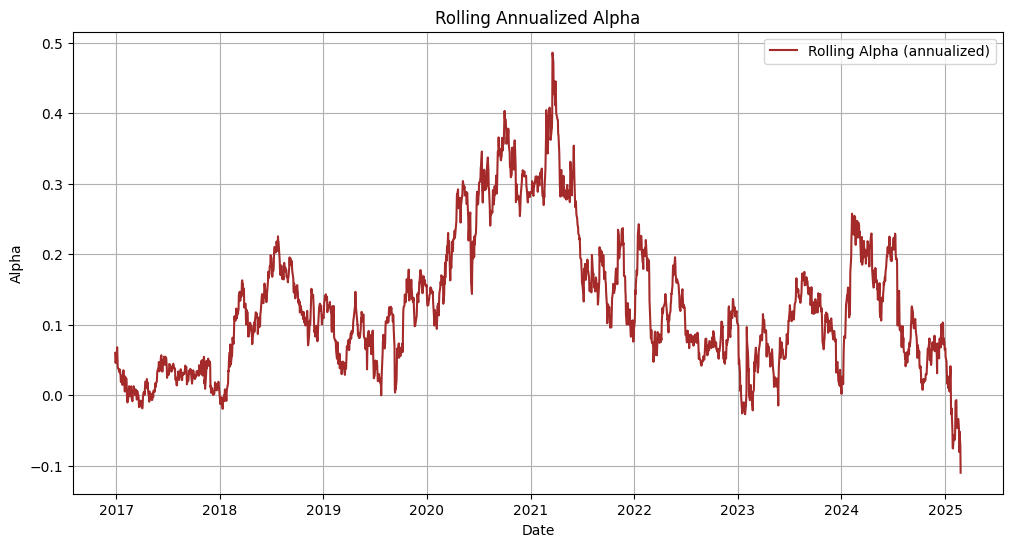

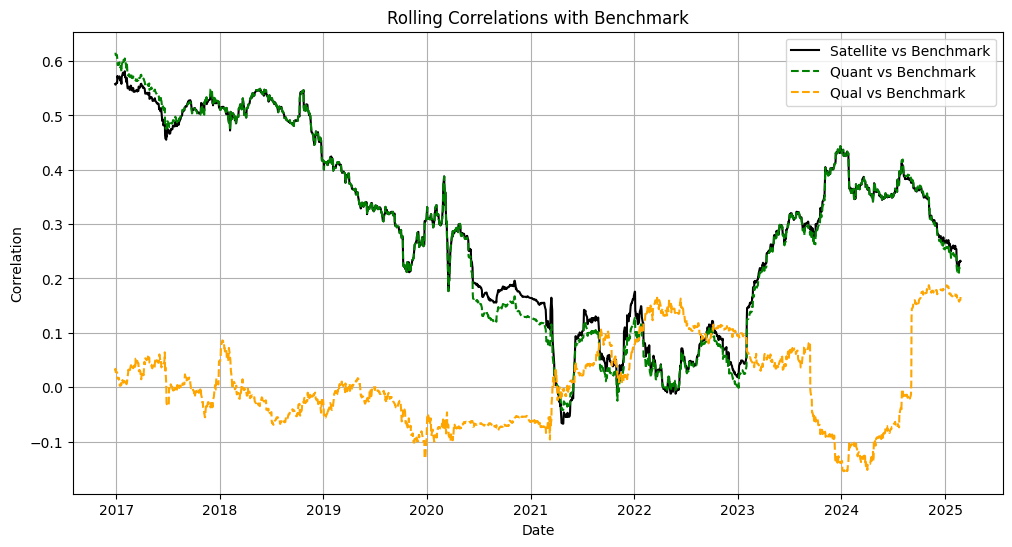

                       Metric     Value
        Annualized Volatility  0.148142
             Maximum Drawdown -0.161354
    Annualized Tracking Error  0.150737
Corr (Satellite vs Benchmark)  0.245151
    Corr (Quant vs Benchmark)  0.220586
     Corr (Qual vs Benchmark)  0.000188
          Global Sharpe Ratio  1.005019
    Global Alpha (annualized)  0.124923
Correlation Matrix:
           Satellite  Benchmark     Quant      Qual
Satellite   1.000000   0.245151  0.971607  0.008558
Benchmark   0.245151   1.000000  0.220586  0.000188
Quant       0.971607   0.220586  1.000000 -0.012257
Qual        0.008558   0.000188 -0.012257  1.000000


In [7]:
# inputs
rebal_periods = 21*6
tc_bps = 0 # we already account for transaction costs in indivudal satellite strategies

# unifying in a df the two satellite strategies
df_satellite = pd.merge(left=rendements_aligned_sat_quant, right=returns_sat_qual, left_index=True, right_index=True, how='inner')
df_satellite.index.name = "Date"
df_satellite.rename(columns={'return strat': 'strat_facto', 'portfolio_returns': 'strat_etfs_funds'}, inplace=True)
df_satellite

quant_strat_aligned,benchmark_series_aligned = Utilities.align_dataframes(df_satellite.iloc[:,0],benchmark_series)
qual_strat_aligned,benchmark_series_aligned = Utilities.align_dataframes(df_satellite.iloc[:,1],benchmark_series)

da = DynamicAllocation(quant_strat_aligned, qual_strat_aligned,benchmark_series_aligned)

#launched the optimization
(quant_weights, qual_weights, sat_returns, semi_vol_annualized_series,
 z_score_series, vol_ex_post_series, vol_ex_ante_series,
 sigma_quant_series, sigma_qual_series) = da.calculate_allocation(
    min_core=0.0,
    window=252,
    ndays_rebal=5,
    method='vol cible',
    k=2,
    risk_budget_core=0.95,
    risk_budget_sat=0.05,
    target_vol=0.15,
    tol=0.02
)

quant_weights.iloc[0] = 0.5 # Set initial weight to 0.5 for the first date

# calculate the weights of the satellite
qual_weights = 1 - quant_weights

# Calculate the cumulative performance of the optimized portfolio
cumulative_performance = (1 + sat_returns).cumprod()

cumulative_quant = (1 + quant_strat_aligned).cumprod()
cumulative_qual = (1 + qual_strat_aligned).cumprod()
cumulative_benchmark_returns = (1 + benchmark_series_aligned).cumprod()

curves_to_plot = {
    "Satellite": cumulative_performance,
    "Benchmark": cumulative_benchmark_returns,
    "Quant strat": cumulative_quant,
    "Qual Strat": cumulative_qual
}

# --- Visualisation ---
viz = Visualizer(semi_vol_annualized_series)
viz.plot_cumulative_performance_multi(curves_to_plot, custom_title="Cumulative Performance: Satellite vs Benchmark, Quant strat & Qual Strat (Points)")
viz.plot_core_sat_weights_area(quant_weights, qual_weights, custom_title="Évolution des Poids: Quant vs Qual",core_label="Quant", sat_label="Qual")

viz.plot_volatilities(
    vol_ex_ante_series=vol_ex_ante_series,
    vol_ex_post_series=vol_ex_post_series,
    core_vol_series=sigma_quant_series,
    sat_vol_series=sigma_qual_series,
    target_vol=0.15,
    tol=0.02,
    title="Volatilities: Ex Ante, Ex Post, Quant, Qual",
    label_core_vol="Vol Strat Quant",
    label_sat_vol="Vol Strat Qual",
    label_ex_ante="Vol Ex-Ante Satellite",
    label_ex_post="Vol Ex-post Satellite",
)
viz.calculate_stats(sat_returns, benchmark_series_aligned, window=252,core_returns=quant_strat_aligned, satellite_returns=qual_strat_aligned,label_portfolio="Satellite",label_benchmark="Benchmark",label_core="Quant",label_satellite="Qual")


Volatilité ex ante et ex post des 2 stratégies satellites

In [8]:
def compute_vol_ex_ante_ex_post(
    df: pd.DataFrame,
    asset_return_cols: list,
    weight_cols: list,
    portfolio_return_col: str,
    freq: str = 'ME',
    window: int = 20,
    name: str = "Strategy"
) -> pd.DataFrame:
    """
    Calcule la volatilité ex ante et ex post pour une stratégie donnée.

    Parameters:
    - df : DataFrame contenant les données
    - asset_return_cols : noms des colonnes de rendements des actifs
    - weight_cols : noms des colonnes de poids
    - portfolio_return_col : colonne des rendements réels du portefeuille
    - freq : fréquence des rebalancements (par défaut = 'M')
    - window : taille de la fenêtre (par défaut = 20 jours)

    Returns:
    - DataFrame avec vol_ex_ante et vol_ex_post
    """
    vol_ex_ante = pd.Series(dtype='float64')
    vol_ex_post = pd.Series(dtype='float64')

    eom = df.resample(freq).last()

    for date in eom.index:
        date_closest = df.index.asof(date)
        if pd.isna(date_closest):
            continue

        try:
            weights = df.loc[date_closest, weight_cols].values
            past_asset_returns = df.loc[:date_closest, asset_return_cols].tail(window)
            if len(past_asset_returns) == window and not past_asset_returns.isnull().values.any():
                portf_simulated = past_asset_returns @ weights
                vol_ex_ante.at[date] = portf_simulated.std() * np.sqrt(252)

            past_portfolio_returns = df.loc[:date_closest, portfolio_return_col].tail(window)
            if len(past_portfolio_returns) == window and not past_portfolio_returns.isnull().any():
                vol_ex_post.at[date] = past_portfolio_returns.std() * np.sqrt(252)

        except Exception as e:
            print(f"[{name}] {date.date()} - {e}")
            continue

    # Combine
    out = pd.DataFrame({
        f'{name}_vol_ex_ante': vol_ex_ante,
        f'{name}_vol_ex_post': vol_ex_post
    })

    return out


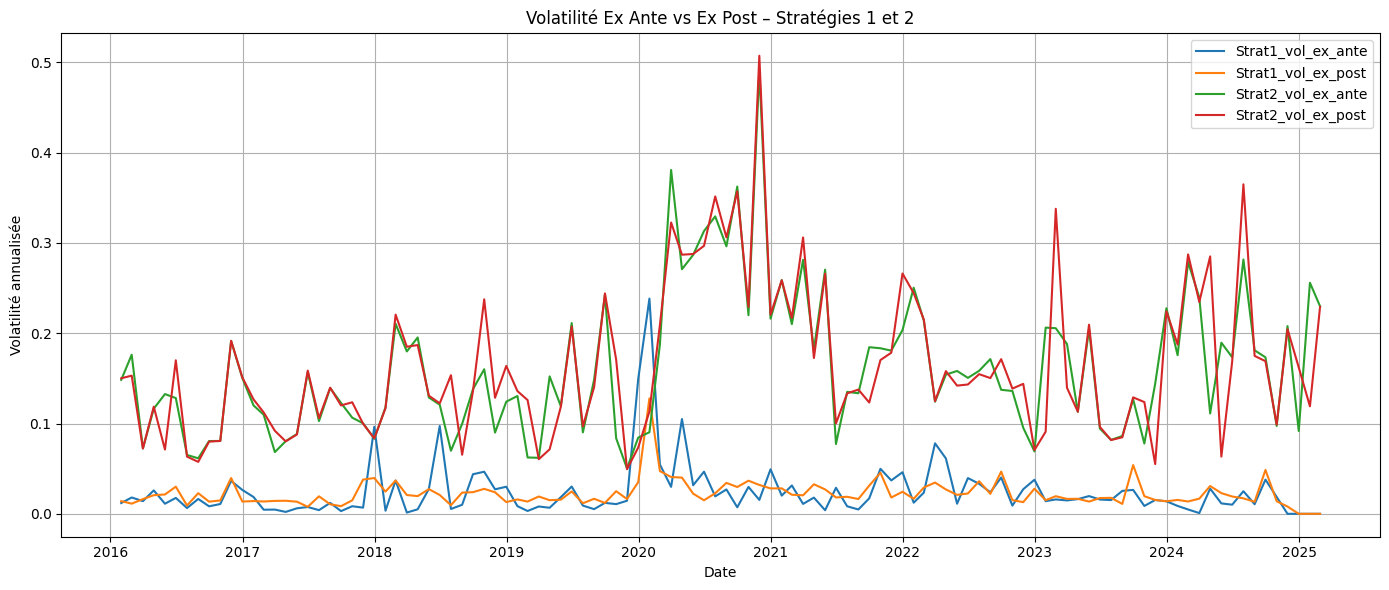

In [9]:
strat1_vol = pd.concat([assets_returns_sat_qual,weights_sat_qual,returns_sat_qual],axis=1).fillna(0)
strat2_vol = df_resultats[['ETF MOM','ETF VALUE','ETF QUALITY','ETF WORLD','Poids M','Poids V','Poids Q','Poids World','return strat']]

df1_vol = compute_vol_ex_ante_ex_post(
    strat1_vol,
    asset_return_cols= assets_returns_sat_qual.columns.tolist(),
    weight_cols= weights_sat_qual.columns.tolist(),
    portfolio_return_col= 'portfolio_returns',
    name='Strat1'
)

df2_vol = compute_vol_ex_ante_ex_post(
    strat2_vol,
    asset_return_cols=['ETF MOM', 'ETF VALUE', 'ETF QUALITY', 'ETF WORLD'],
    weight_cols=['Poids M', 'Poids V', 'Poids Q', 'Poids World'],
    portfolio_return_col='return strat',
    name='Strat2'
)

vol_combined = df1_vol.join(df2_vol, how='inner')

plt.figure(figsize=(14, 6))
for col in vol_combined.columns:
    plt.plot(vol_combined.index, vol_combined[col], label=col)

plt.title("Volatilité Ex Ante vs Ex Post – Stratégies 1 et 2")
plt.ylabel("Volatilité annualisée")
plt.xlabel("Date")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Partie 5 : Optimisation du portefeuille Core-Satellite

- **Méthode de Risk Budgeting**  
  Optimisation basée sur des budgets de risque, où l'allocation est déterminée en fonction des contributions relatives à la volatilité, pondérées par les paramètres de risk budgeting pour le core ($r_{\text{core}}$) et le satellite ($r_{\text{sat}}$) :
  
  $$
  w_{\text{core}} = \frac{\sigma_{\text{sat}} / r_{\text{sat}}}{\sigma_{\text{core}} / r_{\text{core}} + \sigma_{\text{sat}} / r_{\text{sat}}}
  $$


c:\Users\theod\OneDrive\Bureau\Theo\Master IEF Dauphine\S2\Cross Asset investments solution\ppt\Meyer_Molinaro_Khadir_Domingues\Meyer_Molinaro_Khadir_Domingues\modules\my_packages\strategy.py:482: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  core_weights.fillna(method='ffill', inplace=True)
c:\Users\theod\OneDrive\Bureau\Theo\Master IEF Dauphine\S2\Cross Asset investments solution\ppt\Meyer_Molinaro_Khadir_Domingues\Meyer_Molinaro_Khadir_Domingues\modules\my_packages\strategy.py:484: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  semi_vol_series.fillna(method='ffill', inplace=True)
c:\Users\theod\OneDrive\Bureau\Theo\Master IEF Dauphine\S2\Cross Asset investments solution\ppt\Meyer_Molinaro_Khadir_Domingues\Meyer_Molinaro_Khadir_Domingues\modules\my_packages\strategy.py:485: FutureWarning: Series.fillna with 'm

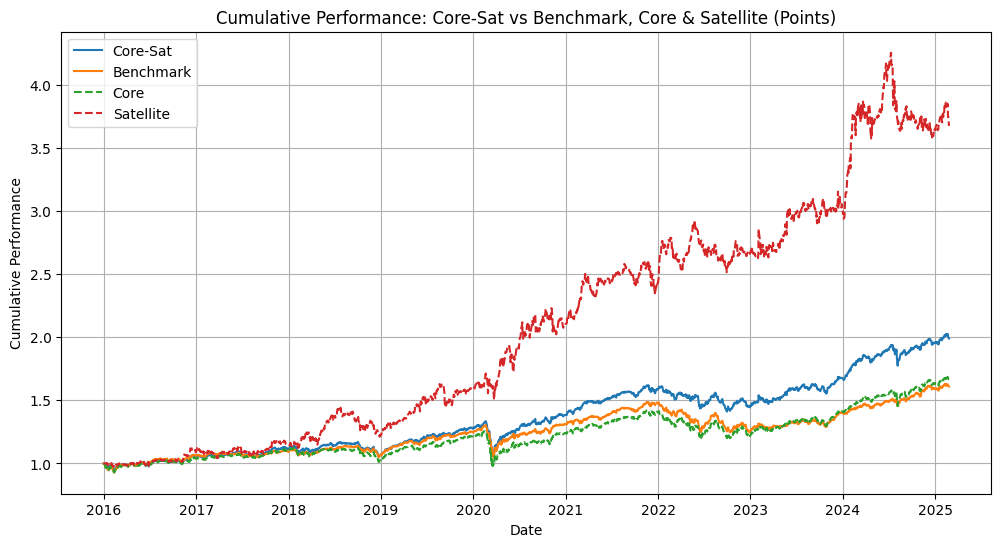

<Figure size 1200x600 with 0 Axes>

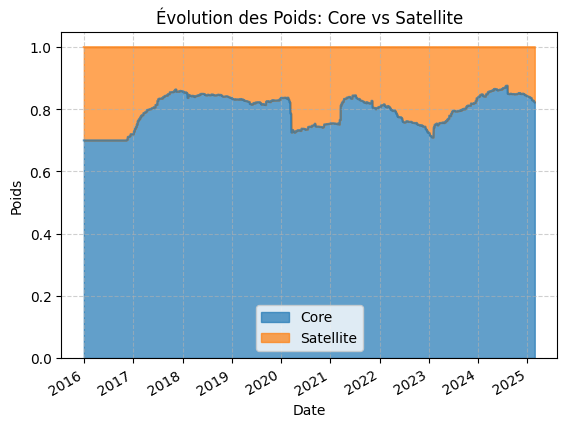

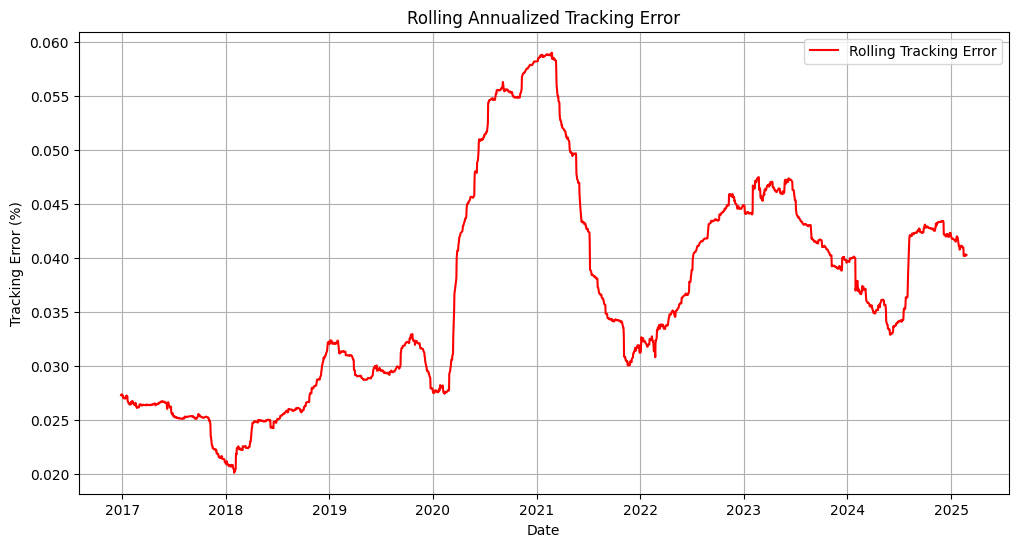

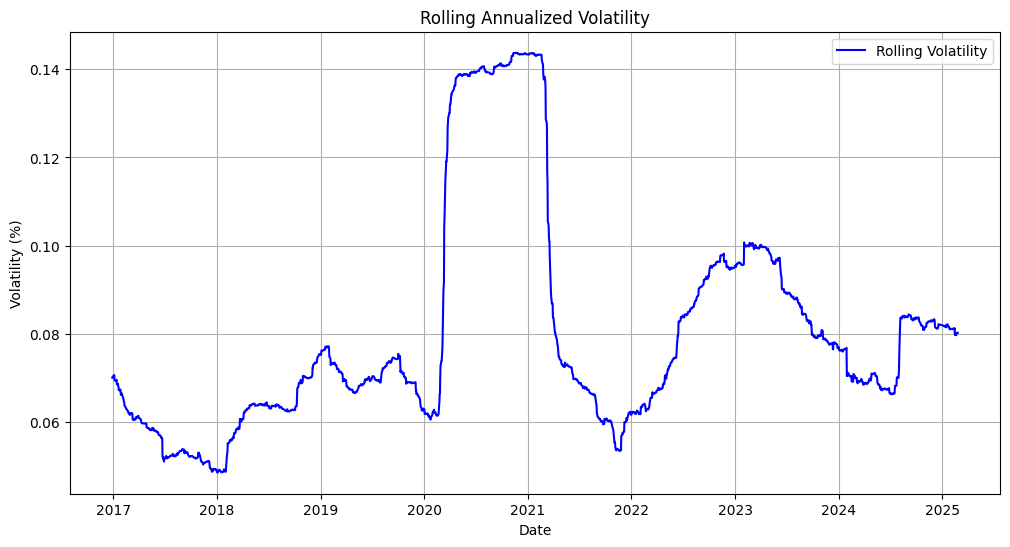

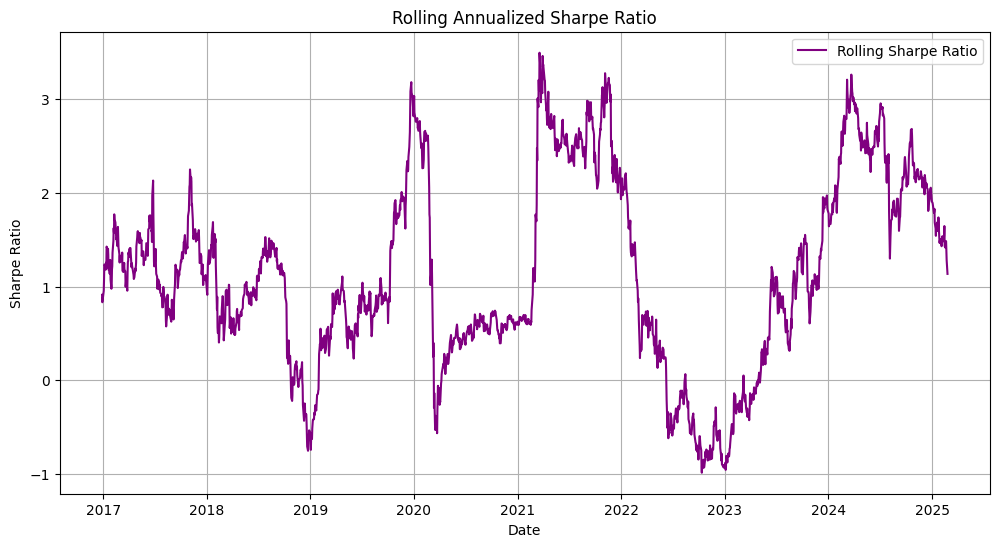

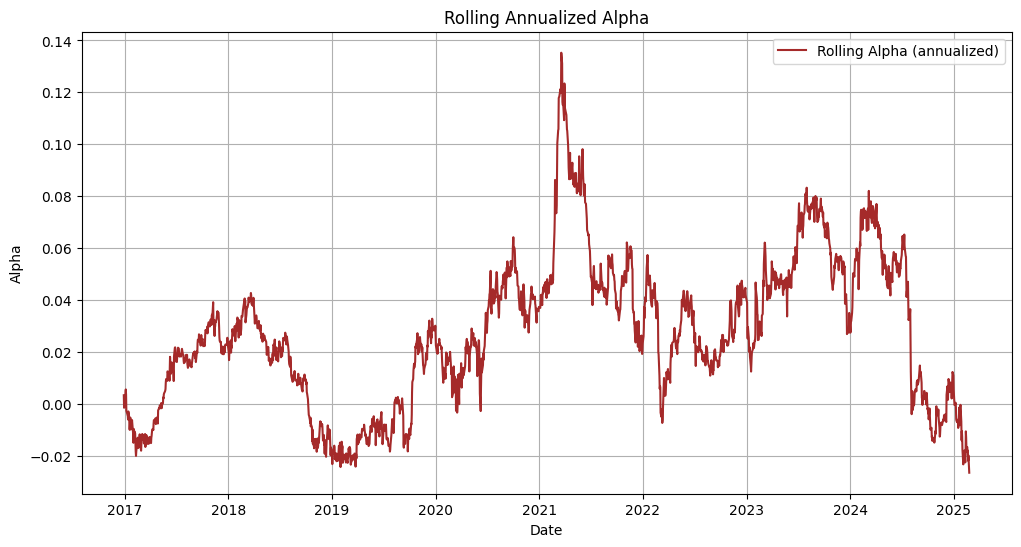

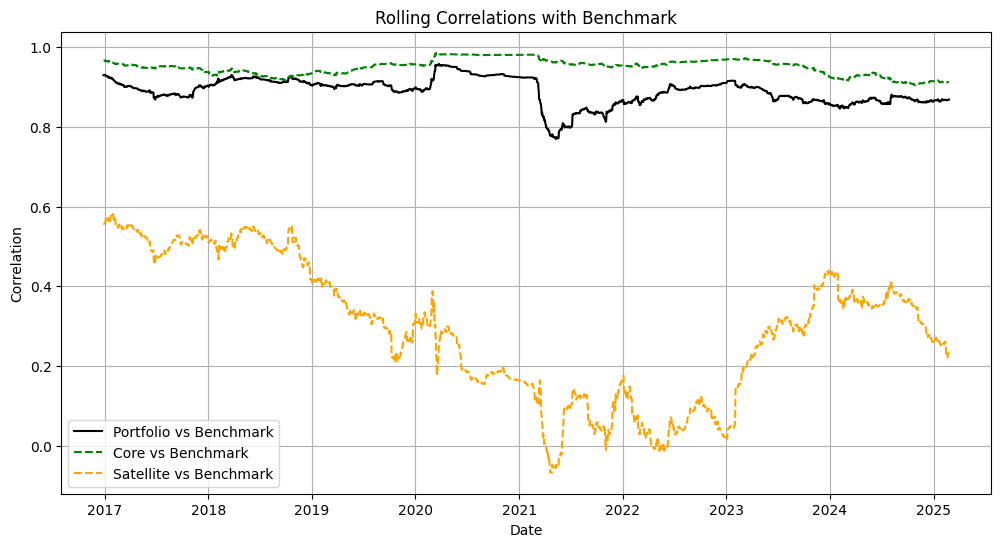

                       Metric     Value
        Annualized Volatility  0.083261
             Maximum Drawdown -0.204521
    Annualized Tracking Error  0.037473
Corr (Portfolio vs Benchmark)  0.897467
     Corr (Core vs Benchmark)  0.958992
Corr (Satellite vs Benchmark)  0.244947
          Global Sharpe Ratio  0.937119
    Global Alpha (annualized)  0.028121
Correlation Matrix:
           Portfolio  Benchmark      Core  Satellite
Portfolio   1.000000   0.897467  0.931449   0.567220
Benchmark   0.897467   1.000000  0.958992   0.244947
Core        0.931449   0.958992  1.000000   0.241760
Satellite   0.567220   0.244947  0.241760   1.000000


In [10]:

core_returns_series_aligned, strategy_returns_aligned = Utilities.align_dataframes(core_returns_series, sat_returns)
benchmark_series = combined_benchmark
benchmark_series_aligned,strategy_returns_aligned = Utilities.align_dataframes(benchmark_series,strategy_returns_aligned)

da = DynamicAllocation(core_returns_series_aligned, strategy_returns_aligned,benchmark_series)

#launched the optimization
(core_weights, satellite_weights, portfolio_returns, semi_vol_annualized_series,
 z_score_series, vol_ex_post_series, vol_ex_ante_series,
 sigma_core_series, sigma_sat_series) = da.calculate_allocation(
    min_core=0.70,
    window=252,
    ndays_rebal=5,
    method='erc',
    k=2,
    risk_budget_core=0.70,
    risk_budget_sat=0.30
)


core_weights.iloc[0] = 0.7 # Set initial weight to 0.7 for the first date

# calculate the weights of the satellite
sat_weights = 1 - core_weights

# Calculate the cumulative performance of the optimized portfolio
cumulative_performance = (1 + portfolio_returns).cumprod()

cumulative_core = (1 + core_returns_series_aligned).cumprod()
cumulative_satellite = (1 + strategy_returns_aligned).cumprod()
cumulative_benchmark_returns = (1 + benchmark_series_aligned).cumprod()

curves_to_plot = {
    "Core-Sat": cumulative_performance,
    "Benchmark": cumulative_benchmark_returns,
    "Core": cumulative_core,
    "Satellite": cumulative_satellite
}

# --- Visualisation ---
viz = Visualizer(semi_vol_annualized_series)
viz.plot_cumulative_performance_multi(curves_to_plot, custom_title="Cumulative Performance: Core-Sat vs Benchmark, Core & Satellite (Points)")
viz.plot_core_sat_weights_area(core_weights, sat_weights, custom_title="Évolution des Poids: Core vs Satellite")
viz.calculate_stats(portfolio_returns, benchmark_series_aligned, window=252,core_returns=core_returns_series_aligned, satellite_returns=strategy_returns_aligned)


# Partie 6 : Visualisation des poids réels et des frais du portefeuille 

Frais annuels moyens supportés : 0.1884%


<Figure size 1200x600 with 0 Axes>

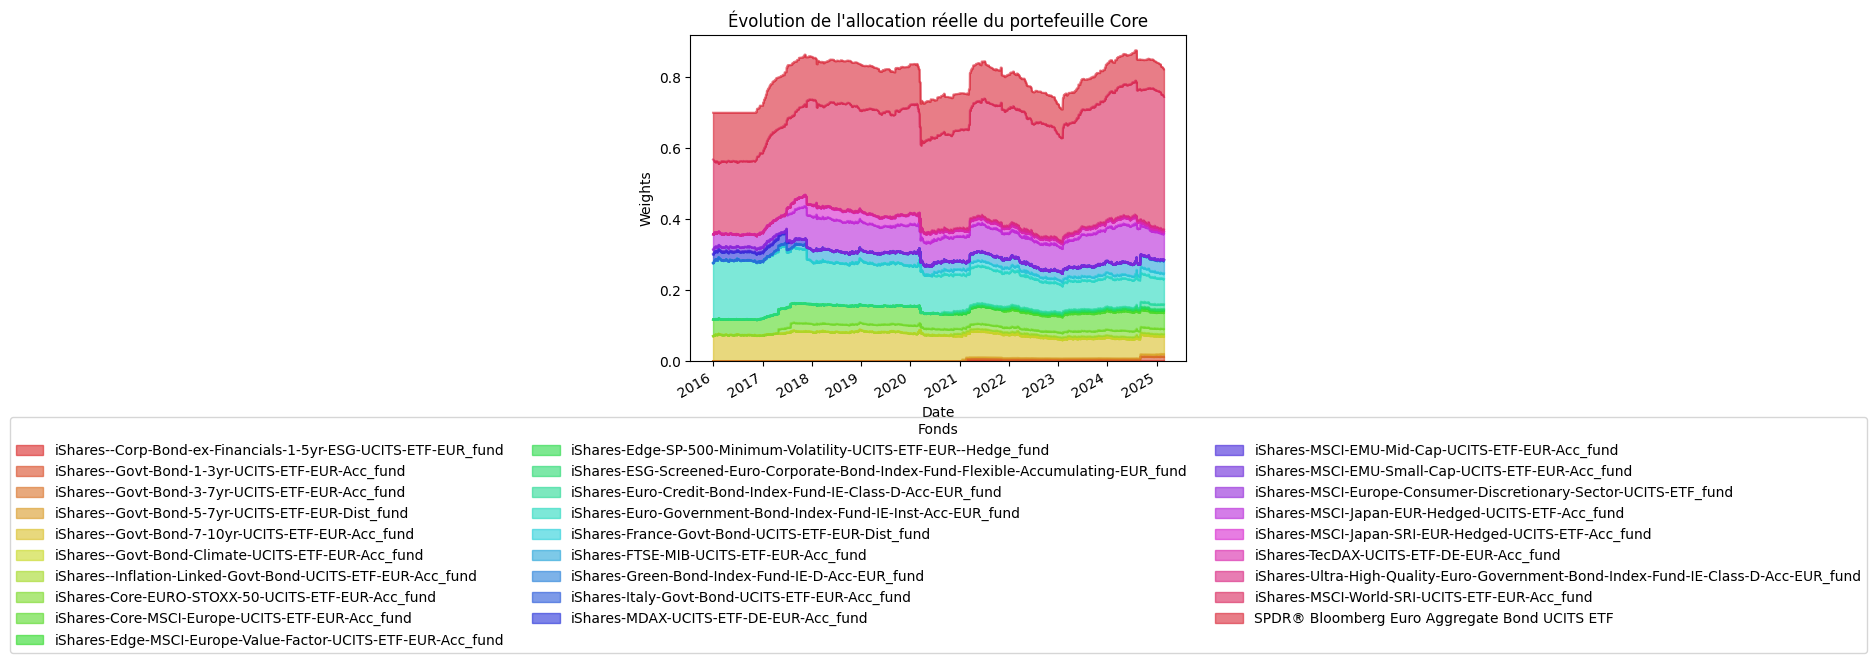

<Figure size 1200x600 with 0 Axes>

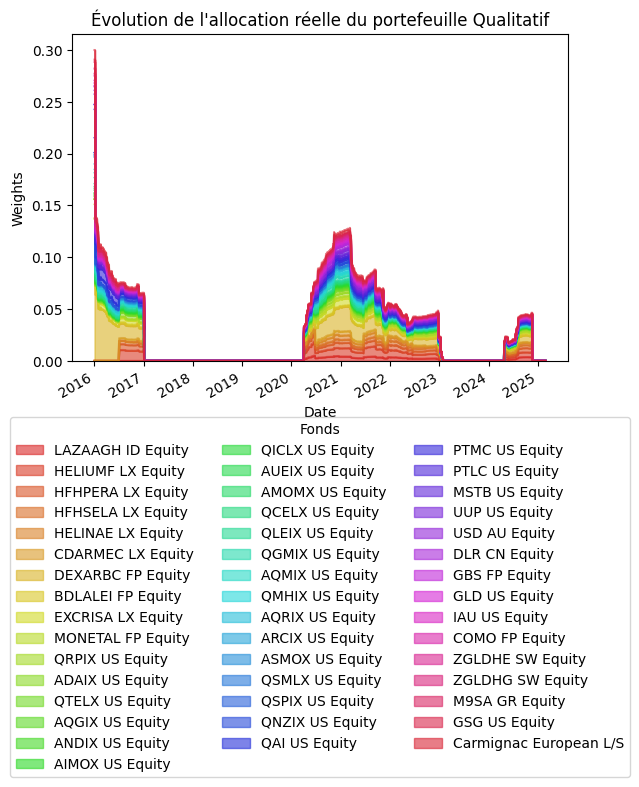

<Figure size 1200x600 with 0 Axes>

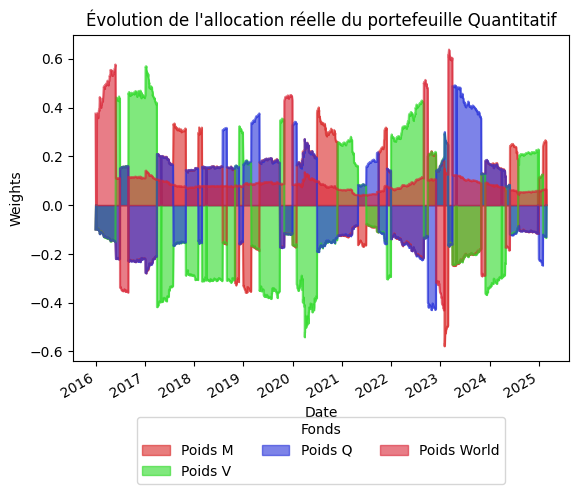

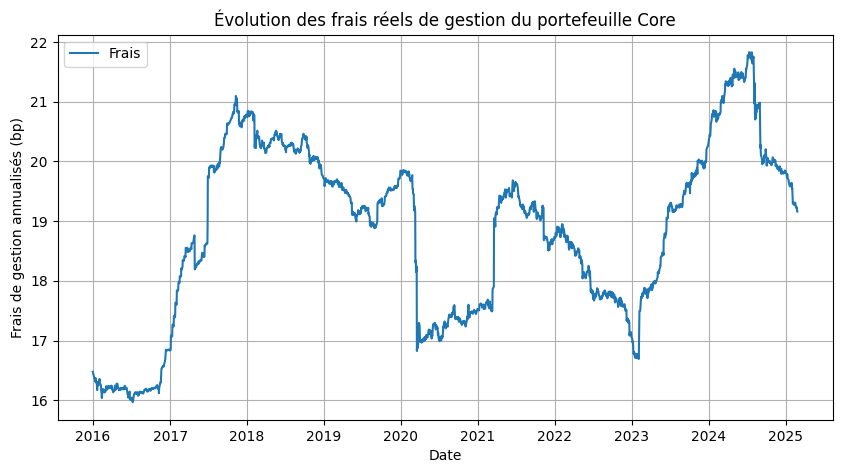

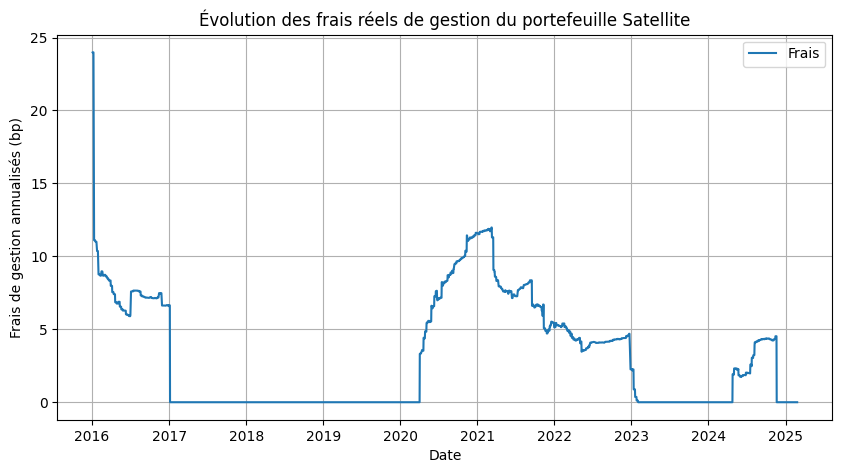

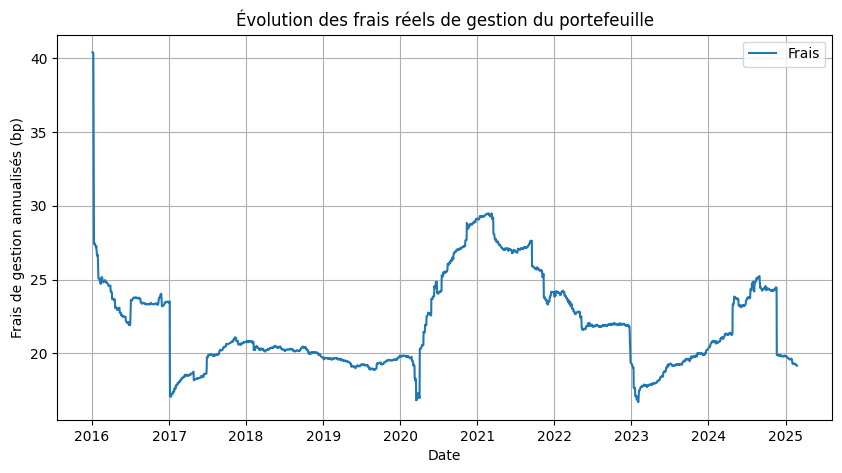

In [11]:
#Weights of the core portfolio
real_poids_core = allocations_core_df.multiply(core_weights, axis=0)
real_poids_core = real_poids_core.iloc[1:]  # Remove the first row (initial weights)
real_poids_core = real_poids_core.iloc[:-1]  # Remove the last row (final weights)

# Weights of the satellite portfolio
real_poids_qual = weights_sat_qual.mul(qual_weights, axis=0).mul(sat_weights, axis=0)
real_poids_qual = real_poids_qual.iloc[2:]  # Remove the first and second row (initial weights)
real_poids_quant = poids.mul(quant_weights, axis=0).mul(sat_weights, axis=0)
sum_real_poids_qual = real_poids_qual.sum(axis=1)

#fees calculation
qual_management_fees_series = qual_management_fees.iloc[:, 0]
real_fees_sat = sum_real_poids_qual * qual_management_fees_series
core_daily_management_fees = Utilities.calculate_management_fees(real_poids_core, fees_df)
real_fees_portfolio = real_fees_sat+ core_daily_management_fees


#Visualisation ---------------------------------------------------------------------------------------------------------------
visualisation = Visualizer(real_poids_core)
visualisation.plot_allocations_evolution(
    real_poids_core, 
    optimization_type="maxir", 
    custom_title="Évolution de l'allocation réelle du portefeuille Core"
)


visualisation.plot_allocations_evolution(
    real_poids_qual, 
    optimization_type="maxir", 
    custom_title="Évolution de l'allocation réelle du portefeuille Qualitatif"
)

visualisation.plot_allocations_evolution(
    real_poids_quant, 
    optimization_type="maxir", 
    custom_title="Évolution de l'allocation réelle du portefeuille Quantitatif",
    stacked = False
)

# 6. Graph of the evolution of the weights of the assets in the portfolio.
visualisation.plot_costs_in_bp(core_daily_management_fees, title="Évolution des frais réels de gestion du portefeuille Core", xlabel="Date", ylabel="Frais de gestion annualisés (bp)", linestyle='-',annualized=True)
visualisation.plot_costs_in_bp(real_fees_sat, title="Évolution des frais réels de gestion du portefeuille Satellite", xlabel="Date", ylabel="Frais de gestion annualisés (bp)", linestyle='-',annualized=True)
visualisation.plot_costs_in_bp(real_fees_portfolio, title="Évolution des frais réels de gestion du portefeuille", xlabel="Date", ylabel="Frais de gestion annualisés (bp)", linestyle='-',annualized=True)

